# Analysis
This jupyter notebook file explains all calculations and data treatment in my master thesis analysis. Please see how the data is obtained and the portfolio returns are calculated in the files *Portfolio Creation*.
I start by importing the relevant libraries and the data files.

In [351]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
from IPython.display import display
from scipy.stats import jarque_bera, kurtosis, norm, pearsonr, skew, ttest_1samp
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

warnings.filterwarnings('ignore')

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

#Size of fonts
plt.rcParams['axes.titlesize'] = 14   # Title size
plt.rcParams['axes.labelsize'] = 11   # Axis label size
plt.rcParams['xtick.labelsize'] = 11  # X-axis tick value size
plt.rcParams['ytick.labelsize'] = 11  # Y-axis tick value size
plt.rcParams['legend.fontsize'] = 11  # Legend font size
plt.rcParams['font.size'] = 11        # Text box size

# Set the style of the plots
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['patch.edgecolor'] = 'none'


# Define the color palette
color_palette = {
    'GS1': '#233D4A',
    'GS5': '#BA1621',
    'FedFunds': '#000000',
    'FEDFUNDS': '#000000',
    'GS10': '#828282',
    'GS1_diff': '#233D4A',
    'GS5_diff': '#BA1621',
    'fedfunds_diff': '#000000',
    'GS10_diff': '#828282',
    'MRP': '#4A7290',  # Lighter shade of blue
    'MRP_log': '#4A7290',
    'SMB': '#3B9C8C',     # Teal, complementary to red
    'HML': '#8B1E3F',     # Darker, richer shade of red/burgundy
    'RMW': '#F4E285',     # Light, soft yellow for highlighting
    'CMA': '#506D2F',     # Deep green/olive
    'RF': '#505050'       # Rich, dark grey
}
color_palette_sector = {
    'NoDur': '#233D4A',
    'Other': '#BA1621',
    'Money': '#000000',
    'Chems': '#828282',
    'Telcm': '#4A7290',
    'Shops': '#3B9C8C',
    'Durbl': '#8B1E3F',
    'Hlth': '#F4E285',
    'Manuf': '#506D2F',
    'Enrgy': '#505050',
    'Utils': '#336699',
    'BusEq': '#999999',
}
color_palette_dr = {
    'high':'#233D4A',
    'mid':'#BA1621',
    'low':'#828282'
}

# Create a variable used as cutoff date for the data
cutoff_date_min = '1970-12-31'
cutoff_date_max = '2023-12-31'

# Significance stars function
def significance_stars(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.10:
        return '*'
    return ''

In [352]:
# Define the paths to the data files
# Portfolio data
path_dr_sector_portfolios = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\DR Sector Monthly Returns.csv'
path_sector_portfolios = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\Sector Monthly Returns.csv'
path_dr_portfolios = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\DR Monthly Returns.csv'
path_overall_portfolios = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\Overall Monthly Returns.csv'

# Independent variables
path_ff_factors = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\F-F_Research_Data_5_Factors_2x3.csv'
path_fedfunds = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\FEDFUNDS.csv'
path_GS1 = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\GS1.csv'
path_GS5 = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\GS5.csv'
path_GS10 = 'C:\\Users\\valde\\OneDrive\\01 Master Thesis\\01 Data\\Data 240402\\Monthly\\GS10.csv'

# Load the CSV files into pandas DataFrames
df_dr_sector_portfolios = pd.read_csv(path_dr_sector_portfolios)
df_sector_portfolios = pd.read_csv(path_sector_portfolios)
df_dr_portfolios = pd.read_csv(path_dr_portfolios)
df_overall = pd.read_csv(path_overall_portfolios)

# Load the CSV files of the independent variables into pandas DataFrames
df_ff_factors = pd.read_csv(path_ff_factors)
df_fedfunds = pd.read_csv(path_fedfunds)
df_GS1 = pd.read_csv(path_GS1)
df_GS5 = pd.read_csv(path_GS5)
df_GS10 = pd.read_csv(path_GS10)

### Initial data treatment
I Change the data format and calculate the change in the interest rates for the variables.

In [353]:
# Calculate the monthly difference in the interest rates
df_fedfunds['fedfunds_diff'] = df_fedfunds['FEDFUNDS'].diff()
df_GS1['GS1_diff'] = df_GS1['GS1'].diff()
df_GS5['GS5_diff'] = df_GS5['GS5'].diff()
df_GS10['GS10_diff'] = df_GS10['GS10'].diff()

# Change the name of the column 'DATE' to 'Date' for FEDFUNDS, GS1, GS5 and GS10
df_fedfunds = df_fedfunds.rename(columns={'DATE': 'Date'})
df_GS1 = df_GS1.rename(columns={'DATE': 'Date'})
df_GS5 = df_GS5.rename(columns={'DATE': 'Date'})
df_GS10 = df_GS10.rename(columns={'DATE': 'Date'})

# Convert the 'Date' column to string
df_dr_sector_portfolios['Date'] = df_dr_sector_portfolios['Date'].astype(str)
df_sector_portfolios['Date'] = df_sector_portfolios['Date'].astype(str)
df_dr_portfolios['Date'] = df_dr_portfolios['Date'].astype(str)
df_overall['Date'] = df_overall['Date'].astype(str)
df_ff_factors['Date'] = df_ff_factors['Date'].astype(str)

# Format the 'Date' column to 'YYYY-MM-01'
df_ff_factors['Date'] = df_ff_factors['Date'].apply(lambda x: f"{x[:4]}-{x[4:]}-01")

# Change the last 2 characters of the 'Date' column to '01' for df_dr_sector_portfolios, df_sector_portfolios and df_dr_portfolios to prepare for merging
df_dr_sector_portfolios['Date'] = df_dr_sector_portfolios['Date'].apply(lambda x: f"{x[:-2]}01")
df_sector_portfolios['Date'] = df_sector_portfolios['Date'].apply(lambda x: f"{x[:-2]}01")
df_dr_portfolios['Date'] = df_dr_portfolios['Date'].apply(lambda x: f"{x[:-2]}01")
df_overall['Date'] = df_overall['Date'].apply(lambda x: f"{x[:-2]}01")

# Change the data type of the column 'Date' to datetime
df_fedfunds['Date'] = pd.to_datetime(df_fedfunds['Date'])
df_GS1['Date'] = pd.to_datetime(df_GS1['Date'])
df_GS5['Date'] = pd.to_datetime(df_GS5['Date'])
df_GS10['Date'] = pd.to_datetime(df_GS10['Date'])
df_dr_sector_portfolios['Date'] = pd.to_datetime(df_dr_sector_portfolios['Date'])
df_ff_factors['Date'] = pd.to_datetime(df_ff_factors['Date'])
df_sector_portfolios['Date'] = pd.to_datetime(df_sector_portfolios['Date'])

#### Merge the independt variables into a single data frame

In [354]:
# Create a data frame for the idenpendt variables
df_ind_var = pd.merge(df_ff_factors, df_fedfunds, on='Date')
df_ind_var = pd.merge(df_ind_var, df_GS1, on='Date')
df_ind_var = pd.merge(df_ind_var, df_GS5, on='Date')
df_ind_var = pd.merge(df_ind_var, df_GS10, on='Date')

# Calculate the slope of the yield curve
df_ind_var['yield_slope'] = df_ind_var['GS10'] - df_ind_var['GS1']
df_ind_var['yield_slope_diff'] = df_ind_var['yield_slope'].diff() # Calculate the change in the yield curve slope

# Filter the data to only include data from 1971-01-01 to 2023-12-31
df_ind_var = df_ind_var[df_ind_var['Date'] >= cutoff_date_min]
df_ind_var = df_ind_var[df_ind_var['Date'] <= cutoff_date_max]

# Calculate the log of the market risk premium
df_ind_var['MRP'] = df_ind_var['Mkt-RF']
df_ind_var['MRP'] = df_ind_var['MRP'] / 100 # Divide MRP by 100
df_ind_var['MRP_log'] = np.log(1 + df_ind_var['MRP'])

# Divide RF by 100
df_ind_var['RF'] = df_ind_var['RF'] / 100

### Display the datasets
I display the datasets to get a overview of the structure and the variables within each dataset. Prior to merging them

In [355]:
# Display the first 5 rows of the DataFrames
display(df_sector_portfolios.head())
display(df_dr_portfolios.head())
display(df_dr_sector_portfolios.head())
display(df_overall.head())
display(df_ind_var.head())

Date sector  weighted_return  weighted_debt_ratio  average_debt_ratio  \
0 1971-01-01  BusEq         0.052212             0.360779            0.444632   
1 1971-02-01  BusEq         0.028695             0.363002            0.444632   
2 1971-03-01  BusEq         0.076852             0.361979            0.444632   
3 1971-04-01  BusEq         0.020884             0.365469            0.452270   
4 1971-05-01  BusEq        -0.063363             0.366232            0.452270   

   company_count  
0          118.0  
1          118.0  
2          118.0  
3          142.0  
4          142.0

Date DR_port  weighted_return  weighted_debt_ratio  \
0  1971-01-01     low         0.030047             0.325783   
1  1971-02-01     low         0.025367             0.324304   
2  1971-03-01     low         0.051465             0.324634   
3  1971-04-01     low         0.035267             0.321522   
4  1971-05-01     low        -0.035476             0.321416   

   average_debt_ratio  company_count  
0            0.280563          499.0  
1            0.280795          500.0  
2            0.280983          501.0  
3            0.279618          583.0  
4            0.279911          585.0

Date DR_sector_port  weighted_return  weighted_debt_ratio  \
0 1971-01-01     BusEq_high         0.073969             0.605304   
1 1971-02-01     BusEq_high         0.007356             0.606560   
2 1971-03-01     BusEq_high         0.121116             0.606250   
3 1971-04-01     BusEq_high         0.055236             0.612162   
4 1971-05-01     BusEq_high        -0.036784             0.609147   

   average_debt_ratio  company_count  
0            0.664650           39.0  
1            0.664650           39.0  
2            0.664650           39.0  
3            0.667118           47.0  
4            0.667118           47.0

Date  weighted_return  weighted_dr    avg_dr  company_count
0  1971-01-01         0.045540     0.435730  0.479186         1492.0
1  1971-02-01         0.025018     0.437154  0.479600         1497.0
2  1971-03-01         0.049133     0.437678  0.480244         1504.0
3  1971-04-01         0.039937     0.437755  0.480035         1746.0
4  1971-05-01        -0.035038     0.437728  0.480335         1756.0

Date  Mkt-RF   SMB   HML   RMW   CMA      RF  FEDFUNDS  \
90 1971-01-01    4.84  7.54  1.33 -1.99  0.07  0.0038      4.14   
91 1971-02-01    1.41  2.04 -1.23  0.62 -0.70  0.0033      3.72   
92 1971-03-01    4.13  2.26 -3.95  1.82 -2.71  0.0030      3.71   
93 1971-04-01    3.15 -0.36  0.69 -1.47  0.87  0.0028      4.16   
94 1971-05-01   -3.98 -1.11 -1.44  1.40  0.25  0.0029      4.63   

    fedfunds_diff   GS1  GS1_diff   GS5  GS5_diff  GS10  GS10_diff  \
90          -0.76  4.57     -0.43  5.89     -0.06  6.24      -0.15   
91          -0.42  3.89     -0.68  5.56     -0.33  6.11      -0.13   
92          -0.01  3.69     -0.20  5.00     -0.56  5.70      -0.41   
93           0.45  4.30      0.61  5.65      0.65  5.83       0.13   
94           0.47  5.04      0.74  6.28      0.63  6.39       0.56   

    yield_slope  yield_slope_diff     MRP   MRP_log  
90         1.67              0.28  0.0484  0.047265  
91         2.22              0.55  0.0141  0.014002  
92         2.01             -0.21  0.0413  0.040470  
93         1.53             -0.48  0.0315  0.031014  
94         1.35             -0.18 -0.0398 -0.040614

# Data Presentation: Interest Rates
- The rates follow each other closely.
- The volatility of shorter rates is the highest, as evidenced by the table.
- There is little to no correlation between the change in interest rates and the nominal level.
- The interest rate changes are not normal distributed: All interest rate changes are negative skewed.

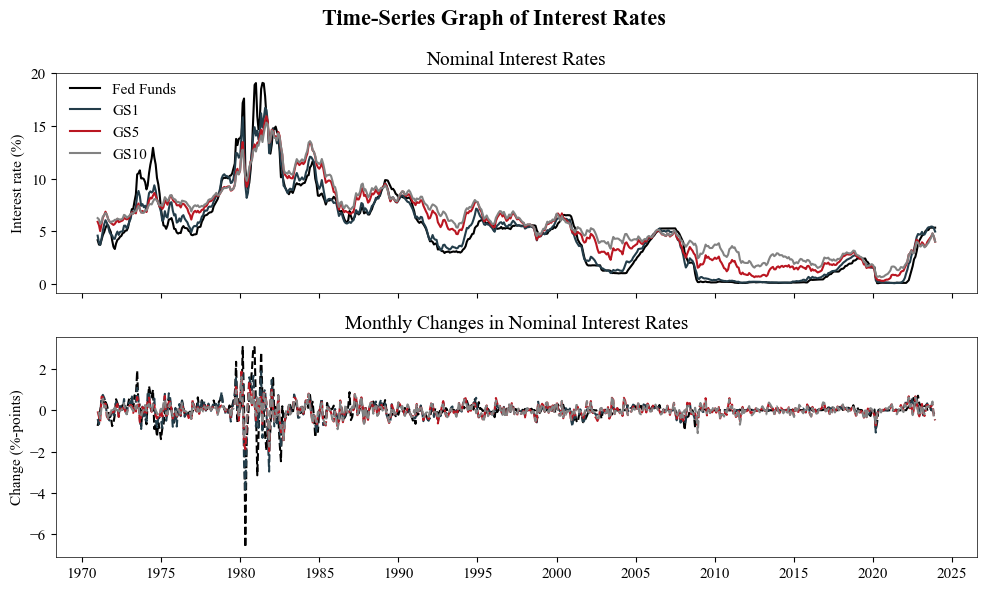

In [356]:
# Create a time-series plot of the interest rates used in the analysis
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date'])
df_ind_var.set_index('Date', inplace=True)  # Setting 'Date' as index for plotting

# Creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plotting the nominal values on the first subplot
ax1.plot(df_ind_var['FEDFUNDS'], label='Fed Funds', color=color_palette['FedFunds'])
ax1.plot(df_ind_var['GS1'], label='GS1', color=color_palette['GS1'])
ax1.plot(df_ind_var['GS5'], label='GS5', color=color_palette['GS5'])
ax1.plot(df_ind_var['GS10'], label='GS10', color=color_palette['GS10'])

ax1.set_title('Nominal Interest Rates')
ax1.set_ylabel('Interest rate (%)')
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.02), frameon=False)

# Plotting the differences on the second subplot
ax2.plot(df_ind_var['fedfunds_diff'], label='FF_diff', linestyle='--', color=color_palette['FedFunds'])
ax2.plot(df_ind_var['GS1_diff'], label='GS1_diff', linestyle='--', color=color_palette['GS1'])
ax2.plot(df_ind_var['GS5_diff'], label='GS5_diff', linestyle='--',color=color_palette['GS5'])
ax2.plot(df_ind_var['GS10_diff'], label='GS10_diff', linestyle='--', color=color_palette['GS10'])

ax2.set_title('Monthly Changes in Nominal Interest Rates')
ax2.set_ylabel('Change (%-points)')

# Set date format on x-axis for both subplots
for ax in [ax1, ax2]:
    ax.set_xticks([pd.Timestamp(f"{year}-01-01") for year in range(1970, 2030, 5)])
    ax.set_xticklabels([str(year) for year in range(1970, 2030, 5)])


# Set the main title for all subplots
fig.suptitle('Time-Series Graph of Interest Rates', fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()

# Resetting the index after plotting
df_ind_var.reset_index(inplace=True)

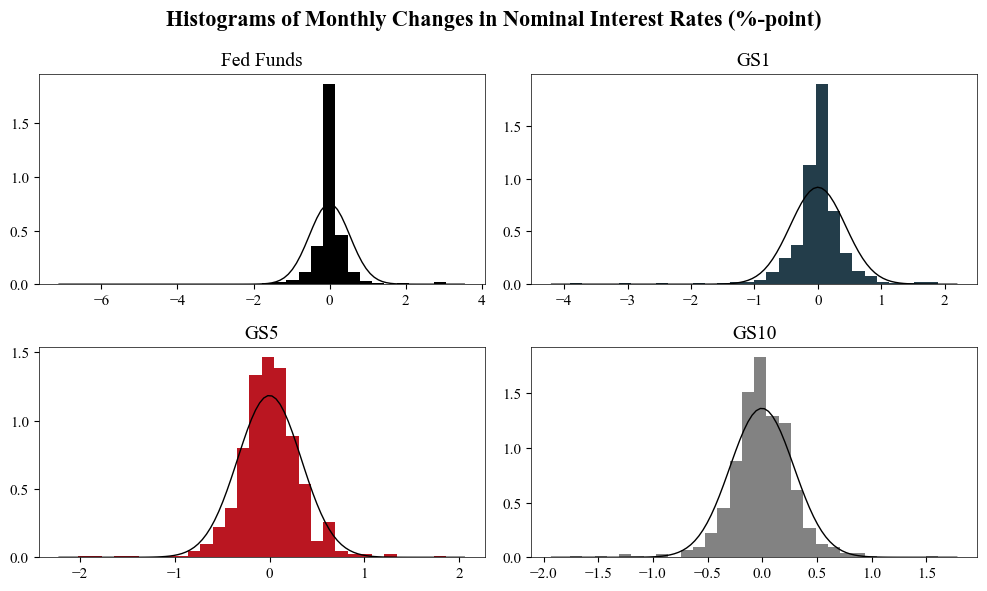

In [357]:
# Convert 'Date' column to datetime format
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date'])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))  # Create a 3x2 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

# Define a mapping of variable names to display names
variable_names = {'fedfunds_diff': 'Fed Funds', 'GS1_diff': 'GS1', 'GS5_diff': 'GS5', 'GS10_diff': 'GS10'}

# Plot a histogram for each variable on its own subplot
for i, (variable, display_name) in enumerate(variable_names.items()):
    data = df_ind_var[variable]
    axes[i].hist(data, bins=30, color=color_palette[variable], label=variable, density=True) 
    
    # Calculate the normal density curve
    mu, std = norm.fit(data)  # Fit a normal distribution to the data
    xmin, xmax = axes[i].get_xlim()  # Get the min and max to define range of x
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    # Plot the normal density curve
    axes[i].plot(x, p, 'k', linewidth=1)
    axes[i].set_title(display_name)

# If there are more axes than plots, turn the extra ones off
for i in range(len(['fedfunds_diff', 'GS1_diff', 'GS5_diff', 'GS10_diff']), len(axes)):
    axes[i].axis('off')

# Add a title to the figure and make the title bold
fig.suptitle('Histograms of Monthly Changes in Nominal Interest Rates (%-point)', fontsize=16, fontweight='bold')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [358]:
selected_columns = ['fedfunds_diff', 'GS1_diff', 'GS5_diff', 'GS10_diff'] # Create a vector of the columns to be investigated
df_numeric = df_ind_var[selected_columns].select_dtypes(include=[np.number]) # Ensure only numeric columns for calculations

# Create the summary statistics for Panel A
summary = pd.DataFrame(index=selected_columns)
summary['Mean'] = df_numeric.mean().round(4)
summary['Std Dev'] = df_numeric.std().round(4)
summary['Skewness'] = df_numeric.apply(skew).round(4)
summary['Kurtosis'] = df_numeric.apply(kurtosis).round(4)
summary['Min'] = df_numeric.min().round(4)
summary['Max'] = df_numeric.max().round(4)
summary['J-B p-Value'] = df_numeric.apply(lambda x: jarque_bera(x)[1]).round(4)

# Format the p-value column with asterisks for significance
summary['J-B p-Value'] = summary['J-B p-Value'].apply(lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else '')

# Create the correlation matrix for Panel B
correlation = df_numeric.corr().round(4)

display(summary)
display(correlation)

Mean  Std Dev  Skewness  Kurtosis   Min   Max J-B p-Value
fedfunds_diff  0.0007   0.5315   -2.4256   46.9220 -6.63  3.06         ***
GS1_diff      -0.0001   0.4346   -1.5226   17.5435 -3.91  1.90         ***
GS5_diff      -0.0031   0.3372   -0.3821    6.2045 -2.03  1.86         ***
GS10_diff     -0.0037   0.2930   -0.3905    5.3989 -1.76  1.61         ***

fedfunds_diff  GS1_diff  GS5_diff  GS10_diff
fedfunds_diff         1.0000    0.6746    0.4377     0.3357
GS1_diff              0.6746    1.0000    0.8653     0.7723
GS5_diff              0.4377    0.8653    1.0000     0.9601
GS10_diff             0.3357    0.7723    0.9601     1.0000

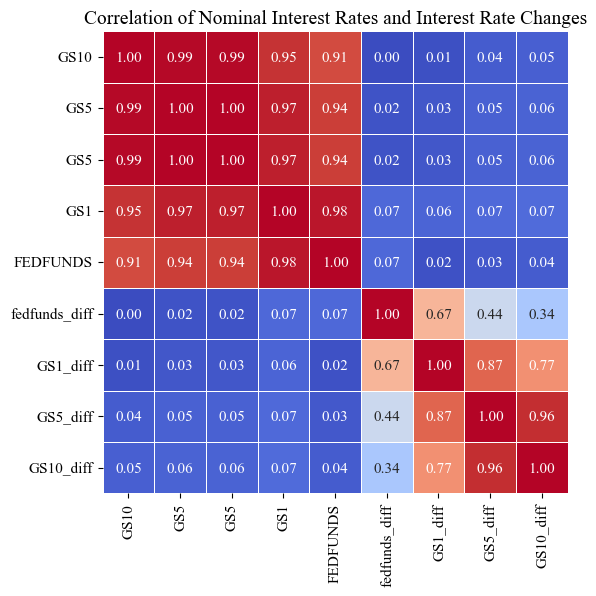

In [359]:
# Create a correlation matrix
correlation = df_ind_var[['GS10','GS5', 'GS5', 'GS1', 'FEDFUNDS', 'fedfunds_diff', 'GS1_diff', 'GS5_diff', 'GS10_diff']].corr().round(4)

# Start a figure with specified size to accommodate both heatmaps
plt.figure(figsize=(6, 6)) 
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
plt.title('Correlation of Nominal Interest Rates and Interest Rate Changes')
plt.xlabel('')  
plt.ylabel('') 
plt.yticks(rotation=0)

plt.show()

In [360]:
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date'])

# Define time periods
time_periods = {
    'Overall': (df_ind_var['Date'].min(), df_ind_var['Date'].max()),
    '71-80': ('1970-01-01', '1980-01-01'),
    '80-90': ('1980-01-01', '1990-01-01'),
    '90-00': ('1990-01-01', '2000-01-01'),
    '00-10': ('2000-01-01', '2010-01-01'),
    '10-20': ('2010-01-01', '2020-01-01'),
    '20-24': ('2020-01-01', '2024-01-01')
}

# Initialize a dictionary to store the results
results = {}

# Calculate mean and standard deviation for each time period
for period, (start, end) in time_periods.items():
    mask = (df_ind_var['Date'] >= start) & (df_ind_var['Date'] <= end)
    filtered_data = df_ind_var.loc[mask, 'GS10_diff']
    mean_val = filtered_data.mean()
    std_val = filtered_data.std()
    results[period] = {'Mean': mean_val, 'Standard Deviation': std_val}

# Output the results
for period, stats in results.items():
    print(f"{period} - Mean: {stats['Mean']:.4f}, Standard Deviation: {stats['Standard Deviation']:.4f}")

Overall - Mean: -0.0037, Standard Deviation: 0.2930
71-80 - Mean: 0.0405, Standard Deviation: 0.2177
80-90 - Mean: -0.0180, Standard Deviation: 0.4964
90-00 - Mean: -0.0098, Standard Deviation: 0.2294
00-10 - Mean: -0.0211, Standard Deviation: 0.2397
10-20 - Mean: -0.0151, Standard Deviation: 0.1786
20-24 - Mean: 0.0450, Standard Deviation: 0.2480


# Data Presentation: Fama-French Factors
- Most factors follow economic events, especially the dot-com bubble, which is evident in the factors' magnitudes.
- The factors are not normally distributed: MRP and RMW are negatively skewed, while SMB, HML, and CMA are positively skewed.
- SMB has a positive correlation with MRP.
- SMB, HML, RMW, and CMA have a negative correlation with MRP.

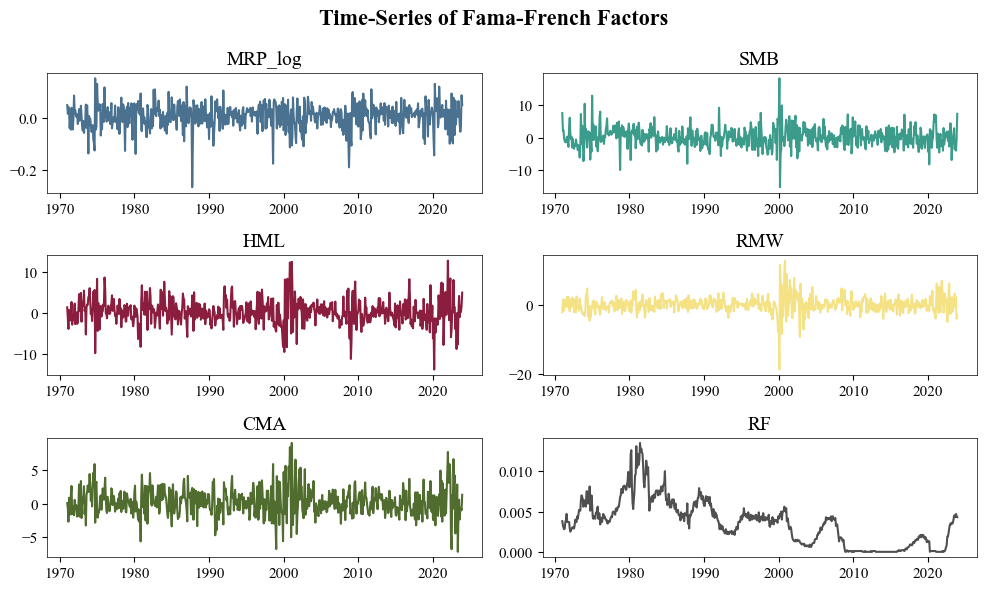

In [361]:
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date']) # Convert 'Date' column to datetime format

df_ind_var.set_index('Date', inplace=True) # Setting 'Date' as the index of df_ind_var for plotting

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))  # Create a 3x2 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

# Plot each variable on its own subplot
for i, variable in enumerate(['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'RF']):
    axes[i].plot(df_ind_var.index, df_ind_var[variable], label=variable, color=color_palette[variable])
    axes[i].set_title(variable)
    axes[i].grid(False)

# If there are more axes than plots, turn the extra ones off
for i in range(len(['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'RF']), len(axes)):
    axes[i].axis('off')

# Add a title to the figure
fig.suptitle('Time-Series of Fama-French Factors', fontsize=16, fontweight='bold')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()
df_ind_var.reset_index(inplace=True) # Resetting the index for later use

#### Histograms of the Fama-French factors

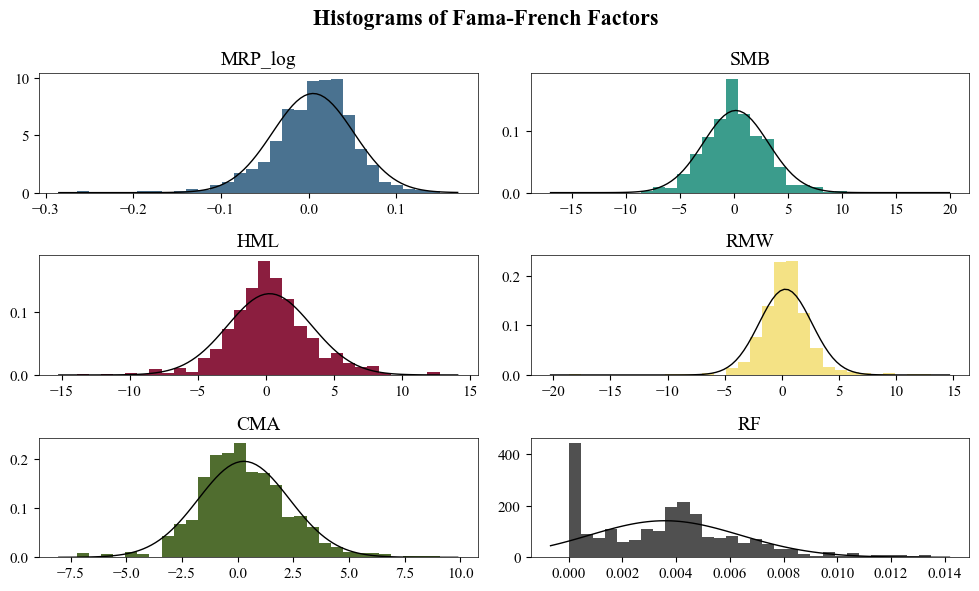

In [362]:
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date']) # Convert 'Date' column to datetime format

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))  # Create a 3x2 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

# Plot a histogram for each variable on its own subplot
for i, variable in enumerate(['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'RF']):
    data = df_ind_var[variable]
    axes[i].hist(data, bins=30, color=color_palette[variable], label=variable, density=True)  # Use density=True for normalization
    
    # Calculate the normal density curve
    mu, std = norm.fit(data)  # Fit a normal distribution to the data: get mean and standard deviation
    xmin, xmax = axes[i].get_xlim()  # Get the min and max to define range of x
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    # Plot the normal density curve
    axes[i].plot(x, p, 'k', linewidth=1)
    axes[i].set_title(variable)

# If there are more axes than plots, turn the extra ones off
for i in range(len(['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'RF']), len(axes)):
    axes[i].axis('off')

# Add a title to the figure
fig.suptitle('Histograms of Fama-French Factors', fontsize=16, fontweight='bold')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [363]:
selected_columns = ['MRP_log', 'SMB', 'HML', 'RMW', 'CMA'] # Create a vector of the columns to be investigated
df_numeric = df_ind_var[selected_columns].select_dtypes(include=[np.number]) # Ensure only numeric columns for calculations

# Create the summary statistics for Panel A
summary = pd.DataFrame(index=selected_columns)
summary['Mean'] = df_numeric.mean().round(4)
summary['Std Dev'] = df_numeric.std().round(4)
summary['Skewness'] = df_numeric.apply(skew).round(4)
summary['Kurtosis'] = df_numeric.apply(kurtosis).round(4)
summary['Min'] = df_numeric.min().round(4)
summary['Max'] = df_numeric.max().round(4)
summary['J-B p-Value'] = df_numeric.apply(lambda x: jarque_bera(x)[1]).round(4)

# Format the p-value column with asterisks for significance
summary['J-B p-Value'] = summary['J-B p-Value'].apply(lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else '')

# One-sample t-test against zero mean
summary['T-Test p-Value'] = df_numeric.apply(lambda x: ttest_1samp(x, 0).pvalue).round(4)
summary['Mean'] = summary['Mean'].astype(str) + summary['T-Test p-Value'].apply(significance_stars)

# Create the correlation matrix for Panel B
correlation = df_numeric.corr().round(4)
p_values = pd.DataFrame(index=selected_columns, columns=selected_columns)

# Calculate p-values for correlations
for col in selected_columns:
    for row in selected_columns:
        r, p = pearsonr(df_numeric[col], df_numeric[row])
        p_values.at[col, row] = p

# Add significance stars to correlation values
for col in p_values.columns:
    for idx in p_values.index:
        star = significance_stars(p_values.at[idx, col])
        correlation.at[idx, col] = f"{correlation.at[idx, col]}{star}"

display(summary)
display(correlation)

Mean  Std Dev  Skewness  Kurtosis      Min      Max J-B p-Value  \
MRP_log   0.005***   0.0463   -0.7620    2.5571  -0.2645   0.1493         ***   
SMB         0.1658   3.0147    0.3610    3.4739 -15.3200  18.2800         ***   
HML       0.2764**   3.1007    0.0857    2.1401 -13.8700  12.7500         ***   
RMW      0.3153***   2.3045   -0.3037   10.6512 -18.6500  13.0700         ***   
CMA      0.2796***   2.0490    0.3250    1.5452  -7.2200   9.0700         ***   

         T-Test p-Value  
MRP_log          0.0065  
SMB              0.1658  
HML              0.0249  
RMW              0.0006  
CMA              0.0006

MRP_log        SMB         HML         RMW         CMA
MRP_log      1.0***  0.2633***  -0.2059***  -0.2076***  -0.3539***
SMB       0.2633***     1.0***      0.0071   -0.385***     -0.0349
HML      -0.2059***     0.0071      1.0***   0.1297***   0.6842***
RMW      -0.2076***  -0.385***   0.1297***      1.0***      0.0507
CMA      -0.3539***    -0.0349   0.6842***      0.0507      1.0***

# Correlation Between Debt Ratio and Interest Rates
- The nominal interest rates are somewhat correlated with the debt-ratio level across all companies.
  - This relationship varies greatly across different times, as evidenced by the correlation per decade. The last subsection shows a positive correlation during '71-'80, which is also the decade when interest rates increased the most, while debt ratios have increased fairly steadily over time.
- The longer the interest rate, the stronger the correlation with the debt ratio.


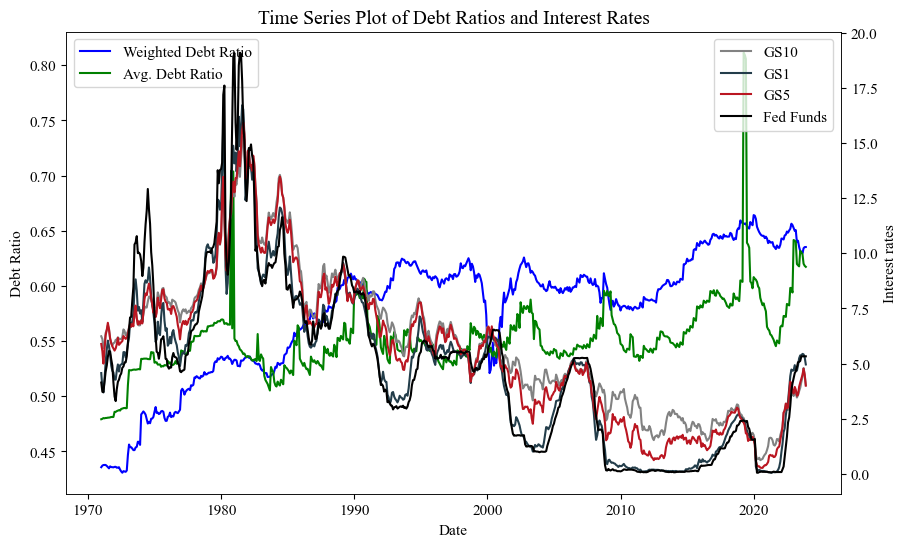

In [364]:
# set data type of 'Date' column to datetime
df_overall['Date'] = pd.to_datetime(df_overall['Date'])
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date'])

# Merge the DataFrames
df_overall = pd.merge(df_overall, df_ind_var, on='Date')

# Subtract the risk-free rate from the returns to calculate the excess return
df_overall['excess_return'] = df_overall['weighted_return'] - df_overall['RF']

# Convert the 'Date' column to datetime
df_overall['Date'] = pd.to_datetime(df_overall['Date'])

# Set 'Date' as the index of the dataframe
df_overall.set_index('Date', inplace=True)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the 'weighted_dr' 'avg_dr' on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Debt Ratio')
ax1.plot(df_overall.index, df_overall['weighted_dr'], color='blue', linestyle='-', label='Weighted Debt Ratio')
ax1.plot(df_overall.index, df_overall['avg_dr'], color='green', linestyle='-', label='Avg. Debt Ratio')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Create a second y-axis for the interest rate variables
ax2 = ax1.twinx()
ax2.set_ylabel('Interest rates')
ax2.plot(df_overall.index, df_overall['GS10'], color=color_palette['GS10'], linestyle='-', label='GS10')
ax2.plot(df_overall.index, df_overall['GS1'], color=color_palette['GS1'], linestyle='-', label='GS1')
ax2.plot(df_overall.index, df_overall['GS5'], color=color_palette['GS5'], linestyle='-', label='GS5')
ax2.plot(df_overall.index, df_overall['FEDFUNDS'], color=color_palette['FEDFUNDS'], linestyle='-', label='Fed Funds')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('Time Series Plot of Debt Ratios and Interest Rates')
plt.show()

df_overall.reset_index(inplace=True) # Reset index for later use

In [365]:
# Define the pairs of interest
pairs = [
    ('weighted_dr', 'FEDFUNDS'),
    ('weighted_dr', 'GS1'),
    ('weighted_dr', 'GS5'),
    ('weighted_dr', 'GS10'),
    ('avg_dr', 'FEDFUNDS'),
    ('avg_dr', 'GS1'),
    ('avg_dr', 'GS5'),
    ('avg_dr', 'GS10')
]

# Initialize an empty list to store the results
results = []

# Calculate correlation and p-value for each pair
for var1, var2 in pairs:
    correlation, p_value = pearsonr(df_overall[var1], df_overall[var2])
    # Convert p-value to percentage and format it
    p_value_percentage = f"{p_value * 100:.4f}%"
    # Compute the Fisher transformation for the correlation
    z = np.arctanh(correlation)
    se = 1/np.sqrt(df_overall[var1].count() - 3)
    z_crit = norm.ppf(0.975)  # two-tailed test for 95% confidence
    z_low = z - z_crit * se
    z_high = z + z_crit * se
    # Inverse Fisher transformation to get the confidence interval for the correlation
    r_low = np.tanh(z_low)
    r_high = np.tanh(z_high)
    # Append the results
    results.append({
        'Variable Pair': f'{var1} x {var2}',
        'Correlation Coefficient': f"{correlation:.4f}",
        'P-value': p_value_percentage,
        'LCL (2.5%)': f"{r_low:.4f}",
        'UCL (97.5%)': f"{r_high:.4f}"
    })

results_df = pd.DataFrame(results)
display(results_df)

Variable Pair Correlation Coefficient  P-value LCL (2.5%)  \
0  weighted_dr x FEDFUNDS                 -0.5256  0.0000%    -0.5797   
1       weighted_dr x GS1                 -0.5333  0.0000%    -0.5868   
2       weighted_dr x GS5                 -0.5614  0.0000%    -0.6124   
3      weighted_dr x GS10                 -0.5663  0.0000%    -0.6169   
4       avg_dr x FEDFUNDS                 -0.2039  0.0000%    -0.2772   
5            avg_dr x GS1                 -0.2347  0.0000%    -0.3069   
6            avg_dr x GS5                 -0.3190  0.0000%    -0.3871   
7           avg_dr x GS10                 -0.3417  0.0000%    -0.4085   

  UCL (97.5%)  
0     -0.4670  
1     -0.4753  
2     -0.5057  
3     -0.5111  
4     -0.1282  
5     -0.1599  
6     -0.2473  
7     -0.2711

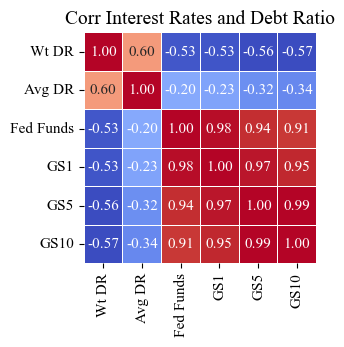

Wt DR  Avg DR  Fed Funds     GS1     GS5    GS10
Wt DR      1.0000  0.6025    -0.5256 -0.5333 -0.5614 -0.5663
Avg DR     0.6025  1.0000    -0.2039 -0.2347 -0.3190 -0.3417
Fed Funds -0.5256 -0.2039     1.0000  0.9822  0.9372  0.9105
GS1       -0.5333 -0.2347     0.9822  1.0000  0.9742  0.9504
GS5       -0.5614 -0.3190     0.9372  0.9742  1.0000  0.9942
GS10      -0.5663 -0.3417     0.9105  0.9504  0.9942  1.0000

In [366]:
# Create a copy of df_overall and rename columns in the copy
df_renamed = df_overall.copy()
new_column_names = {
    'weighted_dr': 'Wt DR',
    'avg_dr': 'Avg DR',
    'GS10': 'GS10',
    'GS1': 'GS1',
    'GS5': 'GS5',
    'FEDFUNDS': 'Fed Funds'
}
df_renamed.rename(columns=new_column_names, inplace=True)

# Create a correlation matrix using the renamed columns
correlation = df_renamed[['Wt DR','Avg DR', 'Fed Funds', 'GS1', 'GS5', 'GS10']].corr().round(4)

# Create heatmap of the correlation matrix
plt.figure(figsize=(3, 3)) 
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
plt.title('Corr Interest Rates and Debt Ratio')
plt.xlabel('')  
plt.ylabel('')  
plt.yticks(rotation=0)
plt.show()

display(correlation)

In [367]:
# Date is converted to datetime format
df_overall['Date'] = pd.to_datetime(df_overall['Date'])

# Define time periods using the correct dataframe
time_periods = {
    'Overall': (df_overall['Date'].min(), df_overall['Date'].max()),
    '71-80': ('1970-01-01', '1980-01-01'),
    '80-90': ('1980-01-01', '1990-01-01'),
    '90-00': ('1990-01-01', '2000-01-01'),
    '00-10': ('2000-01-01', '2010-01-01'),
    '10-20': ('2010-01-01', '2020-01-01'),
    '20-24': ('2020-01-01', '2024-01-01')
}

# Calculate correlation for each time period
correlations = {}
for period, (start_date, end_date) in time_periods.items():
    # Filter the dataframe for the time period
    period_df = df_overall[(df_overall['Date'] >= pd.to_datetime(start_date)) & (df_overall['Date'] <= pd.to_datetime(end_date))]
    # Calculate the correlation
    correlation = period_df[['weighted_dr', 'GS10']].corr().iloc[0, 1].round(4)
    correlations[period] = correlation

correlations


{'Overall': -0.5663,
 '71-80': 0.8764,
 '80-90': -0.7557,
 '90-00': -0.4324,
 '00-10': -0.5463,
 '10-20': -0.2816,
 '20-24': -0.1765}

# Overall Returns
- The value-weighted returns of all companies included in the analysis are very close to the market risk premium defined by Fama & French.
    - This is expected, as the data collection process is almost identical; the primary difference is the exclusion of companies with insufficient data.

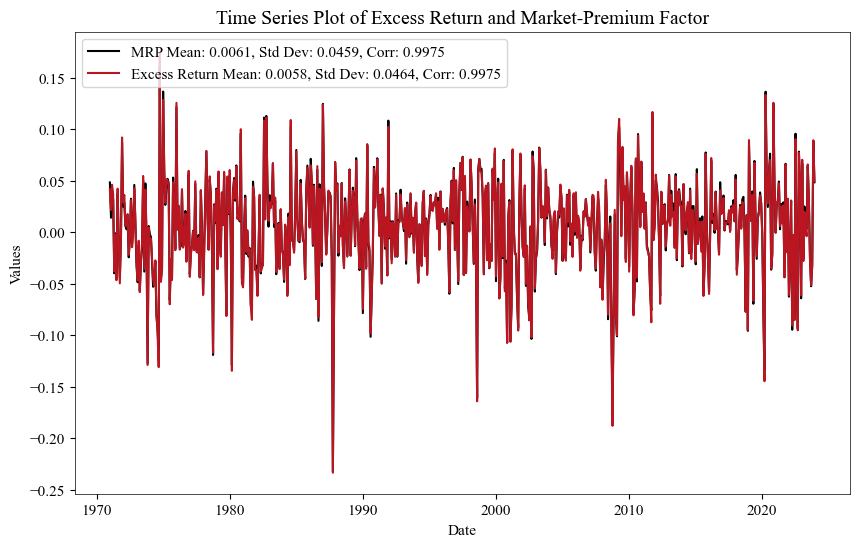

In [368]:
# Set 'Date' as the index of the dataframe
df_overall.set_index('Date', inplace=True)

# Calculate correlation, mean, and standard deviation
correlation = df_overall['excess_return'].corr(df_overall['MRP'])
mean_excess_return = df_overall['excess_return'].mean()
std_excess_return = df_overall['excess_return'].std()
mean_Mkt_RF = df_overall['MRP'].mean()
std_Mkt_RF = df_overall['MRP'].std()
mean_WR = df_overall['weighted_return'].mean()
std_WR = df_overall['weighted_return'].std()

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the 'excess_return' and 'MRP' on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Values')

# Updated labels for the legend with stats and correlation
ax1.plot(df_overall.index, df_overall['MRP'], color='Black', linestyle='-',
         label=f'MRP Mean: {mean_Mkt_RF:.4f}, Std Dev: {std_Mkt_RF:.4f}, Corr: {correlation:.4f}')
ax1.plot(df_overall.index, df_overall['excess_return'], color='#BA1621', linestyle='-',
         label=f'Excess Return Mean: {mean_excess_return:.4f}, Std Dev: {std_excess_return:.4f}, Corr: {correlation:.4f}')

ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

plt.title('Time Series Plot of Excess Return and Market-Premium Factor')
plt.show() 

# Drop index for later use
df_overall.reset_index(inplace=True)



# Data Presentation: Sector Portfolios
- The number of companies included in the analysis varies greatly across the period, from fewer than 2,000 to just shy of 8,000.
- There are differences in volatilities across different sectors.
- The sector portfolio returns are not normally distributed: most have negative skewness, except for Energy, Utilities, and Durable Goods.
- The correlation between sector excess return and MRP varies, however, it is strictly positive for all sectors.
    - Utilities and Energy have the lowest correlation.
- The weighted debt ratio among the sectors varies greatly.
    - Generally, there is an increase in the debt ratio across all sectors.
- There is a correlation between debt ratios and GS10.
    - The correlation varies across sectors as well as over time.
        - There is little correlation between sectors' debt ratios.

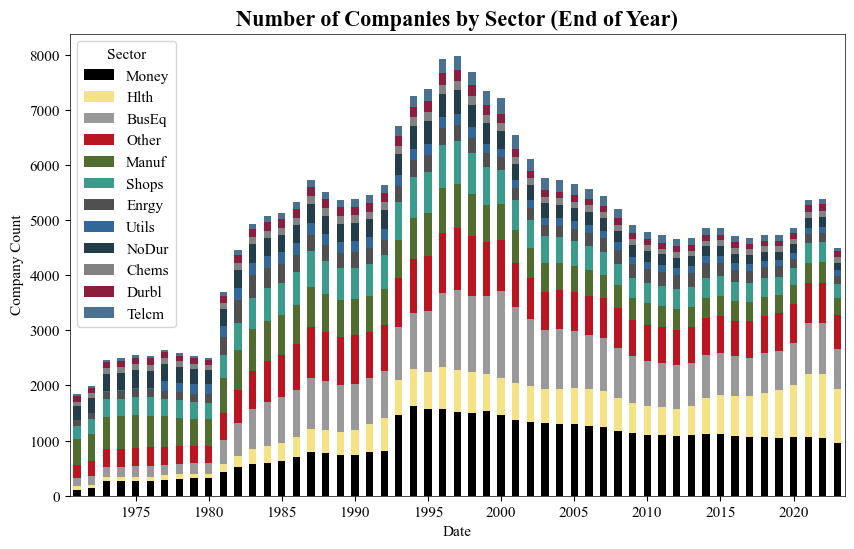

Percentage of months with more than 50 companies per sector: 97.44%


In [369]:
# set data type of 'Date' column to datetime
df_sector_portfolios['Date'] = pd.to_datetime(df_sector_portfolios['Date'])
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date'])

# Merge the DataFrames
df_sector = pd.merge(df_sector_portfolios, df_ind_var, on='Date')

# Subtract the risk-free rate from the returns of the portfolios
df_sector['excess_return'] = df_sector['weighted_return'] - df_sector['RF']
df_sector['excess_return_log']=np.log(1+df_sector['excess_return'])

# set data type of 'Date' column to datetime
df_sector['Date'] = pd.to_datetime(df_sector['Date'])

# Get the last entry for each sector-year combination
df_last_per_year = df_sector.sort_values('Date').groupby([df_sector['Date'].dt.year, 'sector']).tail(1)

# Pivot the data
pivot_df = df_last_per_year.pivot_table(index=df_sector['Date'].dt.year, columns='sector', values='company_count', aggfunc='sum')

# Reorder columns
sector_order = ['Money', 'Hlth', 'BusEq', 'Other', 'Manuf', 'Shops', 'Enrgy', 'Utils', 'NoDur', 'Chems', 'Durbl', 'Telcm']
pivot_df = pivot_df[sector_order]  # Reorder columns based on sector_order

# Apply colors
colors = [color_palette_sector[sector] for sector in sector_order]

# Plot the data
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title('Number of Companies by Sector (End of Year)', fontweight='bold', fontsize=16)
plt.ylabel('Company Count')
plt.legend(title='Sector')

# Adjust the x-axis to display every fifth year starting from 1965
start_year = 1965
years_to_display = [year for year in pivot_df.index if year % 5 == 0 and year >= start_year]

# Set the x-axis ticks and labels
plt.xticks(ticks=[pivot_df.index.get_loc(year) for year in years_to_display], labels=years_to_display, rotation=0)
plt.show()

# Count the percentage of monthly 'company_count' greater than 50
percentage = (df_sector['company_count'] > 50).mean() * 100
print(f"Percentage of months with more than 50 companies per sector: {percentage:.2f}%")

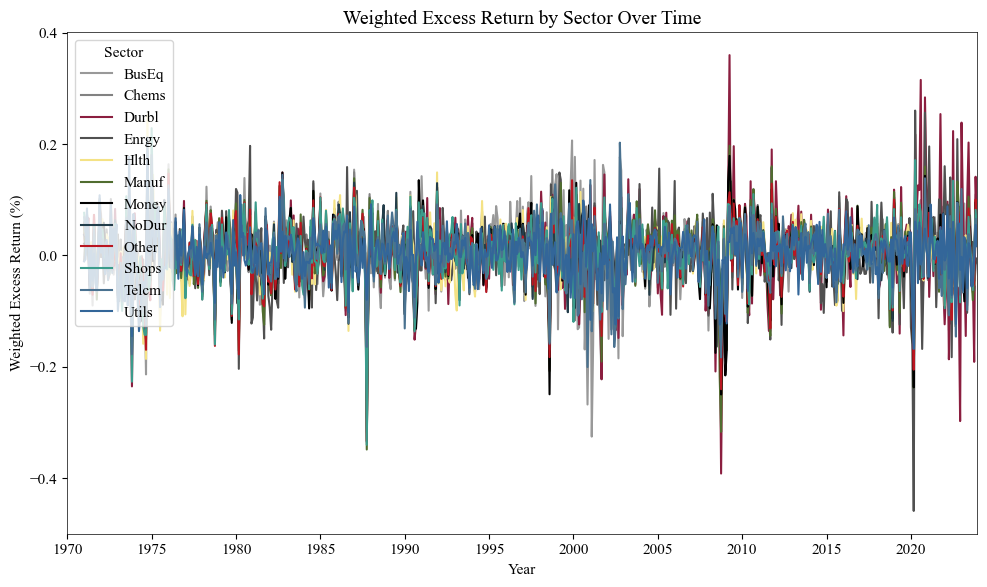

In [370]:
# Ensure 'Date' is in datetime format
df_sector['Date'] = pd.to_datetime(df_sector['Date'])

# Set the 'Date' column as the index of the DataFrame
df_sector.set_index('Date', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

for sector in df_sector['sector'].unique():
    sector_data = df_sector[df_sector['sector'] == sector]
    sector_color = color_palette_sector.get(sector, 'grey')
    sector_data['excess_return_log'].plot(ax=ax, label=sector, color=sector_color)

plt.title('Weighted Excess Return by Sector Over Time')
plt.xlabel('Year')
plt.ylabel('Weighted Excess Return (%)')
plt.legend(title='Sector', loc='upper left')

# Set x-axis dates
ax.set_xticks([pd.Timestamp(f"{year}-01-01") for year in range(1970, 2025, 5)])
ax.set_xticklabels([str(year) for year in range(1970, 2025, 5)])
ax.xaxis.set_minor_locator(plt.NullLocator()) # Disable minor ticks
plt.tight_layout()
plt.show()

# Resetting the index after plotting
df_sector.reset_index(inplace=True)

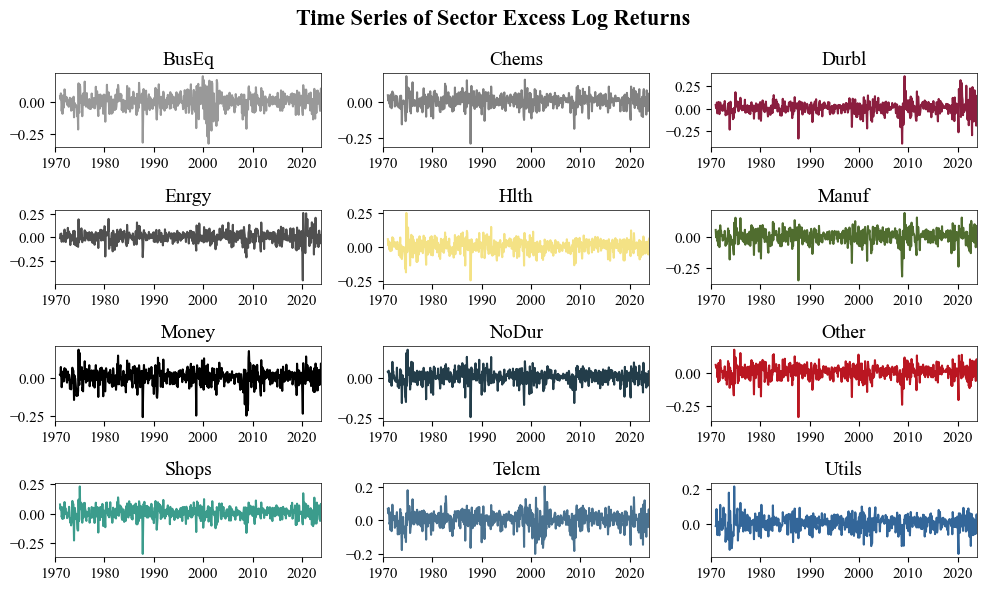

In [371]:
# Convert 'Date' to datetime
df_sector['Date'] = pd.to_datetime(df_sector['Date'])

# Calculate the number of unique sectors to determine subplot grid size
unique_sectors = df_sector['sector'].unique()
n_sectors = len(unique_sectors)

# Apply colors to each sector
colors = [color_palette_sector.get(sector, 'grey') for sector in unique_sectors]

# Determine the number of rows and columns for the subplot grid
n_cols = 3
n_rows = int(np.ceil(n_sectors / n_cols))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 6))
fig.tight_layout(pad=5.0)

# Flatten the axes array for easy indexing
axes_flat = axes.flatten()

for index, sector in enumerate(unique_sectors):
    sector_data = df_sector[df_sector['sector'] == sector][['Date', 'excess_return_log','MRP_log']].dropna()

    if not sector_data.empty:
        ax = axes_flat[index]
        color = colors[index]  # Assign color from palette
        sector_data.plot(x='Date', y='excess_return_log', ax=ax, color=color, legend=False)
        ax.set_title(f'{sector}')
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_xticks([pd.Timestamp(f"{year}-01-01") for year in range(1970, 2025, 10)])
        ax.set_xticklabels([str(year) for year in range(1970, 2025, 10)])
        ax.xaxis.set_minor_locator(plt.NullLocator()) # Disable minor ticks

# Add a title to the figure
fig.suptitle('Time Series of Sector Excess Log Returns', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.5, wspace=0.2)

# Hide any unused subplots
for i in range(n_sectors, n_rows * n_cols):
    axes_flat[i].set_visible(False) 

plt.tight_layout()
plt.show()

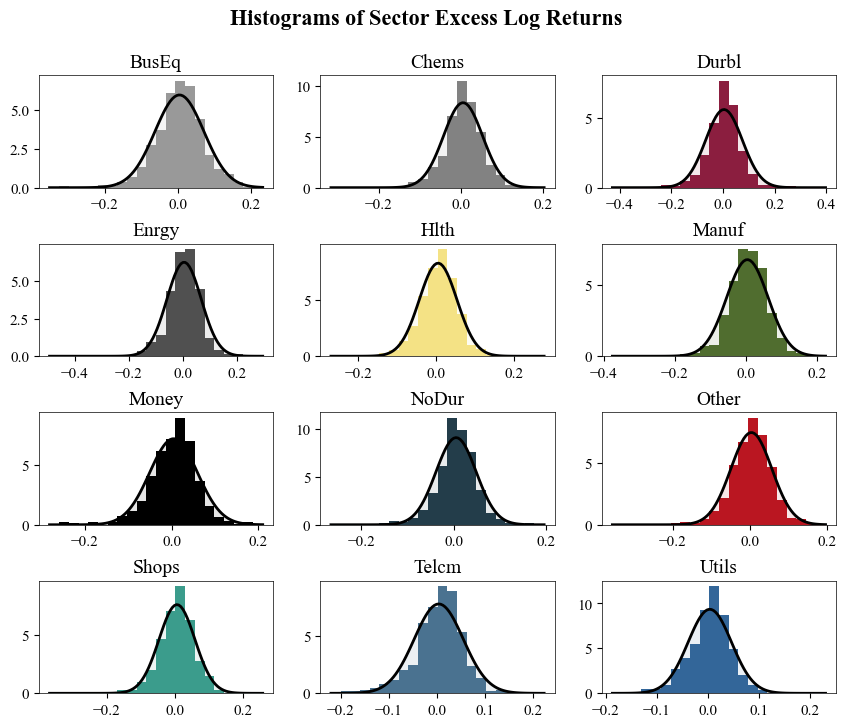

In [372]:
# Calculate the number of unique sectors to determine subplot grid size
unique_sectors = df_sector['sector'].unique()
n_sectors = len(unique_sectors)

# Generate a color palette for each unique sector
colors = [color_palette_sector.get(sector, 'grey') for sector in unique_sectors]

# Determine the number of rows and columns for the subplot grid
n_cols = 3
n_rows = int(np.ceil(n_sectors / n_cols))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 8))
fig.tight_layout(pad=5.0)

# Flatten the axes array for easy indexing
axes_flat = axes.flatten()

for index, sector in enumerate(unique_sectors):
    sector_data = df_sector[df_sector['sector'] == sector]['excess_return_log'].dropna()
    
    # Ensure there's data to plot
    if not sector_data.empty:
        ax = axes_flat[index]
        color = colors[index] 
        ax.hist(sector_data, bins=20, color=color, density=True)
        ax.set_title(f'{sector}')
        
        # Fit a normal distribution to the data
        mu, std = norm.fit(sector_data)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2)
        ax.fill_between(x, p, color=color, alpha=0.1)

# Add a title to the figure
fig.suptitle('Histograms of Sector Excess Log Returns', fontsize=16, fontweight='bold')

# Adjust the layout
plt.subplots_adjust(hspace=0.5, wspace=0.2)

# Hide any unused subplots 
for i in range(n_sectors, n_rows * n_cols):
    axes_flat[i].set_visible(False)

plt.show()

In [373]:
sectors = df_sector['sector'].unique()

# Create the summary statistics DataFrame
summary_stats = pd.DataFrame(index=sectors)

# Calculating summary statistics for each sector
for sector in sectors:
    sector_data = df_sector[df_sector['sector'] == sector]['excess_return_log']
    summary_stats.loc[sector, 'Mean'] = sector_data.mean().round(4)
    summary_stats.loc[sector, 'Std Dev'] = sector_data.std().round(4)
    summary_stats.loc[sector, 'Skewness'] = skew(sector_data).round(4)
    summary_stats.loc[sector, 'Kurtosis'] = kurtosis(sector_data).round(4)
    summary_stats.loc[sector, 'Min'] = sector_data.min().round(4)
    summary_stats.loc[sector, 'Max'] = sector_data.max().round(4)
    jb_test_stat, jb_p_value = jarque_bera(sector_data)
    summary_stats.loc[sector, 'J-B p-Value'] = jb_p_value

# Formatting the p-value column with asterisks for significance
summary_stats['J-B p-Value'] = summary_stats['J-B p-Value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
)

# Displaying the summary statistics table
summary_stats.sort_index(inplace=True)
summary_stats.reset_index(inplace=True)
summary_stats.rename(columns={'index': 'Sector'}, inplace=True)
print("Summary stats of excess_return_log")
display(summary_stats)


Summary stats of excess_return_log


Sector    Mean  Std Dev  Skewness  Kurtosis     Min     Max J-B p-Value
0   BusEq  0.0047   0.0672   -0.5796    2.1771 -0.3255  0.2067         ***
1   Chems  0.0047   0.0477   -0.5942    3.1397 -0.2929  0.1783         ***
2   Durbl  0.0037   0.0714   -0.2466    4.9440 -0.3918  0.3601         ***
3   Enrgy  0.0045   0.0638   -0.5794    5.3764 -0.4590  0.2604         ***
4    Hlth  0.0051   0.0484   -0.3223    2.3664 -0.2452  0.2523         ***
5   Manuf  0.0043   0.0586   -0.9641    4.1990 -0.3486  0.1972         ***
6   Money  0.0045   0.0553   -0.7740    2.9896 -0.2598  0.1881         ***
7   NoDur  0.0055   0.0438   -0.6612    3.0862 -0.2453  0.1756         ***
8   Other  0.0039   0.0535   -0.8039    3.4639 -0.3331  0.1721         ***
9   Shops  0.0056   0.0528   -0.6346    3.6264 -0.3402  0.2288         ***
10  Telcm  0.0037   0.0511   -0.5216    1.6161 -0.2005  0.2028         ***
11  Utils  0.0041   0.0427   -0.2428    1.8413 -0.1680  0.2121         ***

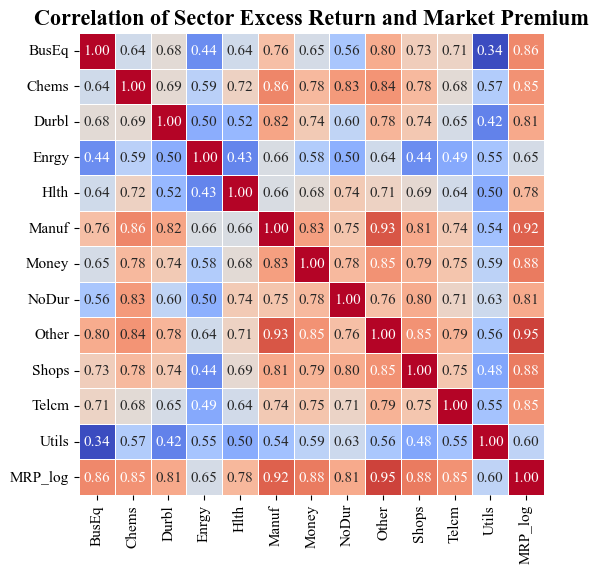

In [374]:
# Ensure 'Date' is datetime
df_sector['Date'] = pd.to_datetime(df_sector['Date'])

# Set appropriate index
df_sector.set_index(['Date', 'sector'], inplace=True)

# Aggregate monthly data
monthly_returns = df_sector.groupby([pd.Grouper(level='Date', freq='M'), 'sector']).mean()

# Prepare data for correlation calculation
monthly_returns.reset_index(inplace=True)
pivot_data = monthly_returns.pivot_table(index='Date', columns='sector', values='excess_return_log')
pivot_data['MRP_log'] = monthly_returns.groupby('Date')['MRP_log'].first()  # Add 'MRP' to the pivot table

# Calculate the correlation matrix
correlation_matrix = pivot_data.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(6, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=.5, cbar=False)

plt.title('Correlation of Sector Excess Return and Market Premium', fontweight='bold', fontsize=16)
plt.xlabel('')  
plt.ylabel('')  
plt.show()

# Resetting the index after plotting
df_sector.reset_index(inplace=True)

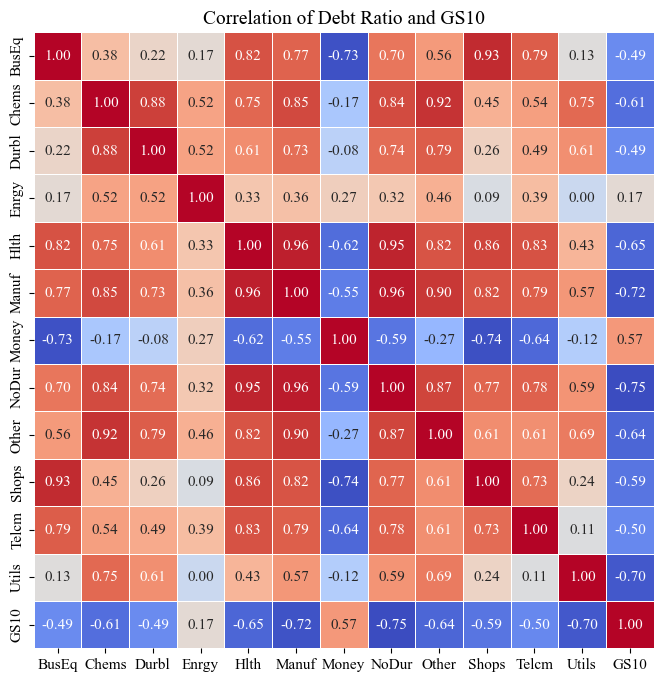

In [375]:
# Ensure 'Date' is datetime
df_sector['Date'] = pd.to_datetime(df_sector['Date'])

# Set appropriate index
df_sector.set_index(['Date', 'sector'], inplace=True)

# Aggregate monthly data
monthly_returns = df_sector.groupby(['Date', 'sector']).mean()

# Prepare data for correlation calculation
monthly_returns.reset_index(inplace=True)
sector_dr_data = monthly_returns.pivot_table(index='Date', columns='sector', values='weighted_debt_ratio')
sector_dr_data['GS10'] = monthly_returns.groupby('Date')['GS10'].first()

# Calculate the correlation matrix
correlation_matrix = sector_dr_data.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=.5, cbar=False) 

plt.title('Correlation of Debt Ratio and GS10')
plt.xlabel('')
plt.ylabel('')
plt.show()

# Resetting the index after plotting
df_sector.reset_index(inplace=True)

# create a copy of sector_dr_data for use later in the analysis (correlation matrix)
sector_dr_data_copy = sector_dr_data.copy()

In [376]:
# Define the pairs of interest
interest_rates = ['FEDFUNDS','GS1','GS5','GS10']
variables = ['weighted_debt_ratio', 'average_debt_ratio']

# Initialize an empty list to store the results
results = []

# Group the DataFrame by 'sector' and then calculate correlations within each group
for sector, group in df_sector.groupby('sector'):
    for variable in variables:
        for rate in interest_rates:
            correlation, p_value = pearsonr(group[variable], group[rate])
            p_value_percentage = f"{p_value * 100:.4f}%"
            z = np.arctanh(correlation)
            se = 1/np.sqrt(group[variable].count() - 3)
            z_crit = norm.ppf(0.975)  # two-tailed test for 95% confidence
            z_low = z - z_crit * se
            z_high = z + z_crit * se
            r_low = np.tanh(z_low)
            r_high = np.tanh(z_high)
            # Append the results
            results.append({
                'Sector': sector,
                'Variable Pair': f'{variable} x {rate}',
                'Correlation Coefficient': f"{correlation:.4f}",
                'P-value': p_value_percentage,
                'LCL (95%)': f"{r_low:.4f}",
                'UCL (95%)': f"{r_high:.4f}"
            })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# sort the DataFrame by  'Variable Pair' and 'Sector'
results_df.sort_values(by=['Variable Pair', 'Correlation Coefficient', 'Sector'], inplace=True)
results_df = results_df.sort_values(by='Sector')

# Display the data frame for the variable pair 'weighted_debt_ratio x GS10'
display(results_df[results_df['Variable Pair'] == 'weighted_debt_ratio x GS10'])

Sector               Variable Pair Correlation Coefficient  P-value  \
3   BusEq  weighted_debt_ratio x GS10                 -0.4894  0.0000%   
11  Chems  weighted_debt_ratio x GS10                 -0.6098  0.0000%   
19  Durbl  weighted_debt_ratio x GS10                 -0.4883  0.0000%   
27  Enrgy  weighted_debt_ratio x GS10                  0.1678  0.0021%   
35   Hlth  weighted_debt_ratio x GS10                 -0.6456  0.0000%   
43  Manuf  weighted_debt_ratio x GS10                 -0.7219  0.0000%   
51  Money  weighted_debt_ratio x GS10                  0.5664  0.0000%   
59  NoDur  weighted_debt_ratio x GS10                 -0.7520  0.0000%   
67  Other  weighted_debt_ratio x GS10                 -0.6431  0.0000%   
75  Shops  weighted_debt_ratio x GS10                 -0.5873  0.0000%   
83  Telcm  weighted_debt_ratio x GS10                 -0.5013  0.0000%   
91  Utils  weighted_debt_ratio x GS10                 -0.7015  0.0000%   

   LCL (95%) UCL (95%)  
3    -0.5464   -0.4279  
11   -0.6565   -0.5586  
19   -0.5454   -0.4268  
27    0.0913    0.2424  
35   -0.6888   -0.5979  
43   -0.7571   -0.6824  
51    0.5112    0.6170  
59   -0.7839   -0.7162  
67   -0.6865   -0.5951  
75   -0.6360   -0.5340  
83   -0.5573   -0.4407  
91   -0.7389   -0.6597

In [377]:
# Initialize an empty list to store the results
results = []

# Define time periods
time_periods = {
    'Overall': (df_sector['Date'].min(), df_sector['Date'].max()),
    "'71-'80": ('1970-01-01', '1980-01-01'),
    "'80-'90": ('1980-01-01', '1990-01-01'),
    "'90-'00": ('1990-01-01', '2000-01-01'),
    "'00-'10": ('2000-01-01', '2010-01-01'),
    "'10-'20": ('2010-01-01', '2020-01-01'),
    "'20-'24": ('2020-01-01', '2024-01-01')
}

# Group the DataFrame by 'sector' and then calculate correlations within each group
for sector, group in df_sector.groupby('sector'):
    results_row = {'Sector': sector}
    for period, (start_date, end_date) in time_periods.items():
        # Filter data by time period
        period_data = group[(group['Date'] >= start_date) & (group['Date'] <= end_date)]
        if len(period_data) > 2:
            correlation, p_value = pearsonr(period_data['weighted_debt_ratio'], period_data['GS10'])
            # Append correlation and significance stars
            results_row[f'Rho {period}'] = f"{correlation:.4f}{significance_stars(p_value)}"
        else:
            results_row[f'Rho {period}'] = 'N/A'
    
    # Append the results
    results.append(results_row)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame by 'Sector'
results_df.sort_values(by=['Sector'], inplace=True)

print("Summary of Correlations with GS10 and Weighted Debt Ratio by Sector and Time Period")
display(results_df)

Summary of Correlations with GS10 and Weighted Debt Ratio by Sector and Time Period


Sector Rho Overall Rho '71-'80 Rho '80-'90 Rho '90-'00 Rho '00-'10  \
0   BusEq  -0.4894***   0.6955***     -0.0681   0.4134***  -0.7628***   
1   Chems  -0.6098***   0.7973***  -0.7727***  -0.7165***   0.2978***   
2   Durbl  -0.4883***   0.8599***  -0.5731***  -0.6919***   0.5010***   
3   Enrgy   0.1678***   0.8756***  -0.5807***   0.6693***   0.2945***   
4    Hlth  -0.6456***   0.8652***  -0.6454***  -0.5299***    -0.1509*   
5   Manuf  -0.7219***   0.8540***  -0.7623***  -0.7969***  -0.4816***   
6   Money   0.5664***   0.5887***  -0.6470***  -0.3136***   0.5704***   
7   NoDur  -0.7520***   0.8554***  -0.7908***  -0.7378***   0.2526***   
8   Other  -0.6431***   0.7060***  -0.5894***  -0.6645***   0.3642***   
9   Shops  -0.5873***   0.8127***  -0.5113***      0.0358  -0.2542***   
10  Telcm  -0.5013***   0.5488***  -0.8080***   0.4380***  -0.8047***   
11  Utils  -0.7015***  -0.4922***  -0.5021***  -0.6916***   0.4601***   

   Rho '10-'20 Rho '20-'24  
0     -0.1764*   0.4762***  
1   -0.3897***  -0.8527***  
2     0.2260**  -0.7491***  
3   -0.5570***  -0.8504***  
4   -0.3688***   0.7058***  
5   -0.2765***  -0.5381***  
6    0.7539***   0.6656***  
7   -0.6163***  -0.3723***  
8   -0.3436***  -0.6298***  
9    -0.2211**     -0.0565  
10  -0.3208***   0.6580***  
11     -0.1483   0.7707***

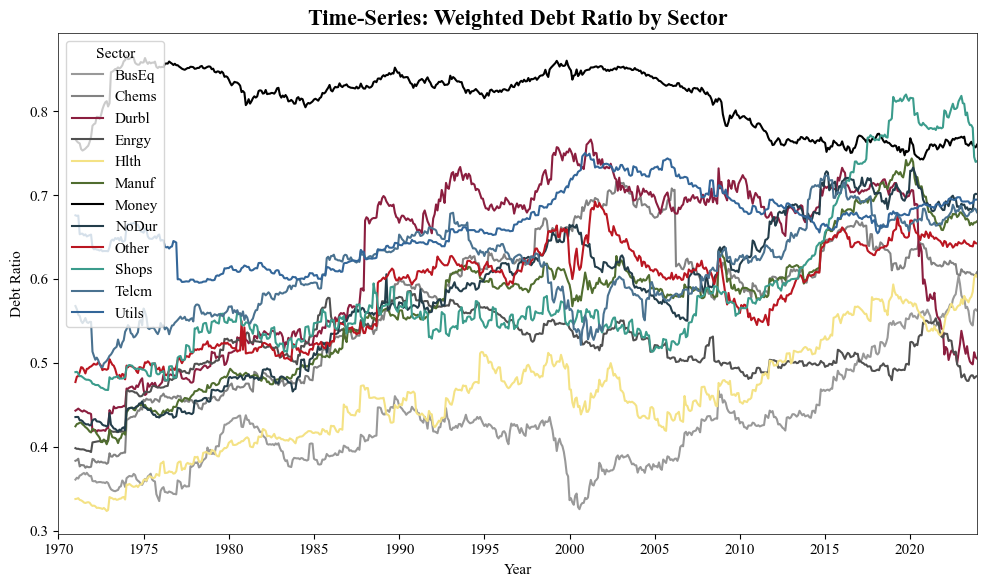

In [378]:
# Ensure 'Date' is in datetime format
df_sector['Date'] = pd.to_datetime(df_sector['Date'])

# Set the 'Date' column as the index of the DataFrame
df_sector.set_index('Date', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

for sector in df_sector['sector'].unique():
    sector_data = df_sector[df_sector['sector'] == sector]
    sector_color = color_palette_sector.get(sector, 'grey')
    sector_data['weighted_debt_ratio'].plot(ax=ax, label=sector, color=sector_color)

plt.title('Time-Series: Weighted Debt Ratio by Sector', fontweight='bold', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Debt Ratio')
plt.legend(title='Sector', loc='upper left')

# Set custom x-axis dates
ax.set_xticks([pd.Timestamp(f"{year}-01-01") for year in range(1970, 2025, 5)])
ax.set_xticklabels([str(year) for year in range(1970, 2025, 5)])
ax.xaxis.set_minor_locator(plt.NullLocator()) # Disable minor ticks

plt.tight_layout()
plt.show()

df_sector.reset_index(inplace=True) # Resetting the index after plotting

In [379]:
# Group by 'sector' and calculate mean and standard deviation
sector_stats = df_sector.groupby('sector')['weighted_debt_ratio'].agg(['mean', 'std', 'count'])

# Define the confidence level
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)

# Calculate the margin of error
sector_stats['margin_of_error'] = z_score * (sector_stats['std'] / np.sqrt(sector_stats['count']))

# Calculate the lower confidence limit (LCL) and upper confidence limit (UCL)
sector_stats['LCL'] = sector_stats['mean'] - sector_stats['margin_of_error']
sector_stats['UCL'] = sector_stats['mean'] + sector_stats['margin_of_error']

# Displaying the final table with Debt Ratio, LCL, and UCL for each sector
sector_stats = sector_stats[['mean', 'LCL', 'UCL']]
sector_stats.columns = ['Debt Ratio', 'LCL', 'UCL']  # Renaming columns for clarity
display(sector_stats)

Debt Ratio       LCL       UCL
sector                                
BusEq     0.424620  0.420033  0.429207
Chems     0.573541  0.566720  0.580363
Durbl     0.626620  0.618891  0.634350
Enrgy     0.515508  0.512456  0.518560
Hlth      0.458821  0.453748  0.463895
Manuf     0.568655  0.562335  0.574975
Money     0.814524  0.811782  0.817266
NoDur     0.582227  0.575238  0.589216
Other     0.584481  0.580010  0.588953
Shops     0.583377  0.576342  0.590412
Telcm     0.612057  0.608023  0.616091
Utils     0.664405  0.661277  0.667533

In [380]:
# Ensure 'Date' is datetime type and set it as the index
df_sector['Date'] = pd.to_datetime(df_sector['Date'])
df_sector.set_index('Date', inplace=True)

# Function to perform ADF Test
def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations Used': result[3],
        'IC Best': result[5]
    }

# Initialize an empty DataFrame to store ADF test results
adf_results_df = pd.DataFrame()

# Apply the ADF test to each sector and store results in DataFrame
for sector in df_sector['sector'].unique():
    sector_data = df_sector[df_sector['sector'] == sector]['excess_return_log'].dropna()
    adf_result = perform_adf_test(sector_data)
    adf_result['Sector'] = sector
    adf_results_df = pd.concat([adf_results_df, pd.DataFrame([{
        'Sector': adf_result['Sector'],
        'Test Statistic': adf_result['Test Statistic'],
        'P-value': adf_result['p-value']
    }])], ignore_index=True)

print('ADF Test Results for Excess Return Log')
display(adf_results_df)

# Resetting the index after operations
df_sector.reset_index(inplace=True)

ADF Test Results for Excess Return Log


Sector  Test Statistic       P-value
0   BusEq      -23.951229  0.000000e+00
1   Chems      -24.740781  0.000000e+00
2   Durbl       -7.090435  4.424753e-10
3   Enrgy      -25.813505  0.000000e+00
4    Hlth      -25.687452  0.000000e+00
5   Manuf      -23.128369  0.000000e+00
6   Money      -10.719384  3.179704e-19
7   NoDur      -18.154100  2.471390e-30
8   Other      -23.762798  0.000000e+00
9   Shops      -18.129858  2.507839e-30
10  Telcm       -6.321696  3.054999e-08
11  Utils      -10.144806  8.239404e-18

# Debt ratio portfolios
- The mid group has the highest returns while being the least volatile.
- The low group has a positive correlation between debt ratio and GS10.
- The mid group has the highest correlation with MRP.
    - While the correlation in the high group is almost the same, it is substantially lower in the low group.

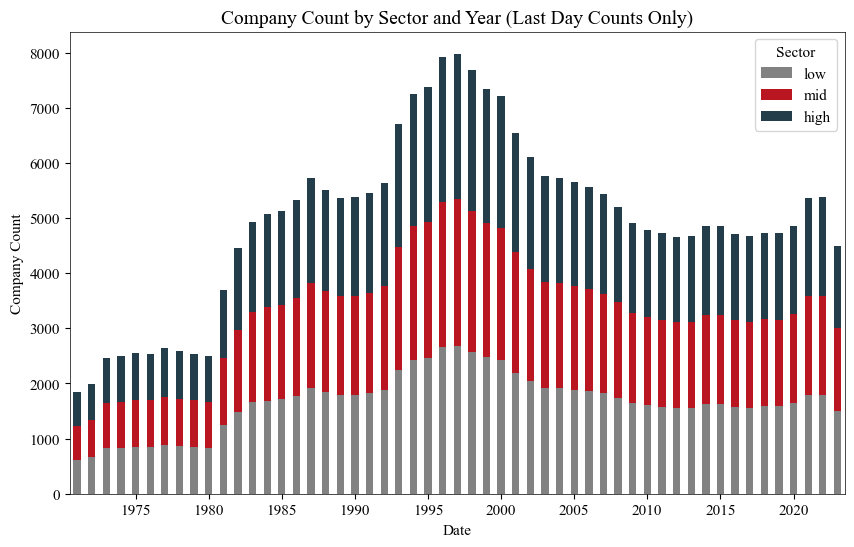

In [381]:
# set data type of 'Date' column to datetime
df_dr_portfolios['Date'] = pd.to_datetime(df_dr_portfolios['Date'])
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date'])
df_dr = pd.merge(df_dr_portfolios, df_ind_var, on='Date') # Merge the DataFrames

# Subtract the risk-free rate from the returns of the portfolios
df_dr['excess_return'] = df_dr['weighted_return'] - df_dr['RF']
df_dr['excess_return_log']=np.log(1+df_dr['excess_return'])

# Ensure 'Date' is in datetime format
df_dr['Date'] = pd.to_datetime(df_dr['Date'])

# Get the last entry for each sector-year combination
df_last_per_year = df_dr.sort_values('Date').groupby([df_dr['Date'].dt.year, 'DR_port']).tail(1)

# Pivot the data
pivot_df = df_last_per_year.pivot_table(index=df_dr['Date'].dt.year, columns='DR_port', values='company_count', aggfunc='sum')

# Reorder columns according to the specified sector order
port_order = ['low', 'mid', 'high']
pivot_df = pivot_df[port_order]  # Reorder columns based on sector_order

# Apply colors to the plot
colors = [color_palette_dr[DR_port] for DR_port in port_order]  # Updated to match the reordered sectors

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title('Company Count by Sector and Year (Last Day Counts Only)')
plt.ylabel('Company Count')
plt.legend(title='Sector')

# Adjust the x-axis to display every fifth year
start_year = 1970
years_to_display = [year for year in pivot_df.index if year % 5 == 0 and year >= start_year]
plt.xticks(ticks=[pivot_df.index.get_loc(year) for year in years_to_display], labels=years_to_display, rotation=0)

plt.show()

In [382]:
average_data = df_dr.groupby('DR_port')[['company_count', 'weighted_debt_ratio']].mean()
average_data['company_count']=average_data['company_count'].round(0)
average_data['weighted_debt_ratio']=average_data['weighted_debt_ratio'].round(4)
# Display the resulting DataFrame
display(average_data)


company_count  weighted_debt_ratio
DR_port                                    
high            1661.0               0.8153
low             1662.0               0.2974
mid             1661.0               0.5409

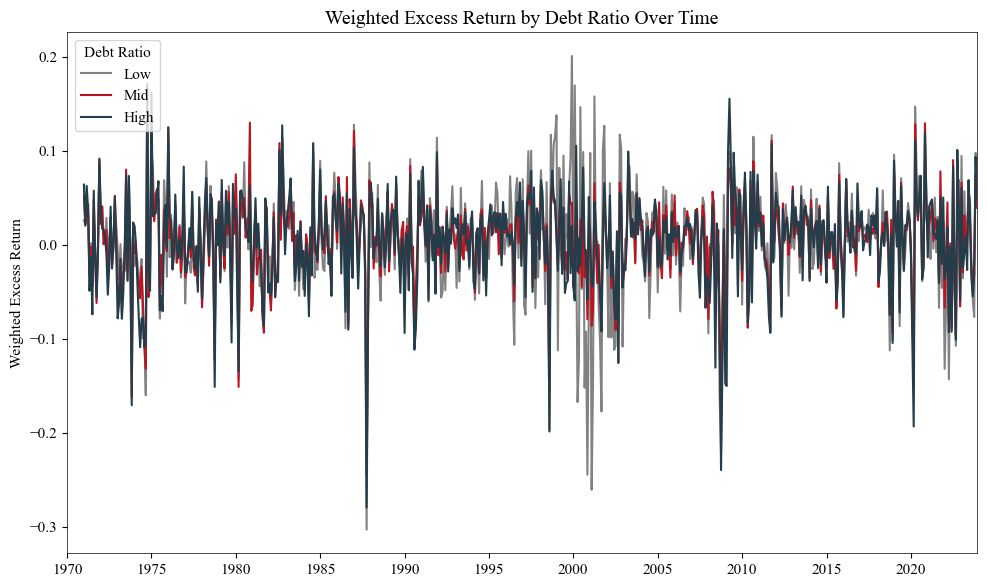

In [383]:
# Ensure 'Date' is in datetime format
df_dr['Date'] = pd.to_datetime(df_dr['Date'])

# Set the 'Date' column as the index of the DataFrame
df_dr.set_index('Date', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare the color palette for the sectors
for DR_port in df_dr['DR_port'].unique():
    dr_data = df_dr[df_dr['DR_port'] == DR_port]
    dr_color = color_palette_dr.get(DR_port, 'grey')
    dr_data['excess_return_log'].plot(ax=ax, label=DR_port.title(), color=dr_color)

plt.title('Weighted Excess Return by Debt Ratio Over Time')
plt.xlabel('')
plt.ylabel('Weighted Excess Return')
plt.legend(title='Debt Ratio', loc='upper left')

# Set custom x-axis dates
ax.set_xticks([pd.Timestamp(f"{year}-01-01") for year in range(1970, 2025, 5)])
ax.set_xticklabels([str(year) for year in range(1970, 2025, 5)])
ax.xaxis.set_minor_locator(plt.NullLocator()) # Disable minor ticks

plt.tight_layout()
plt.show()

df_dr.reset_index(inplace=True) # Resetting the index after plotting

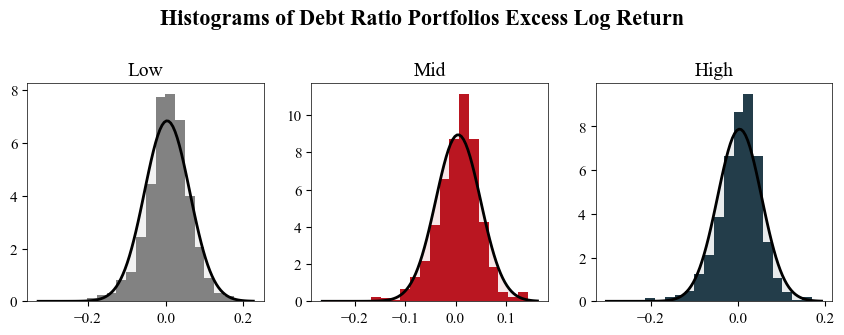

In [384]:
# Calculate the number of unique sectors to determine subplot grid size
unique_dr = df_dr['DR_port'].unique()
n_port = len(unique_dr)

# Generate a color palette 
colors = [color_palette_dr.get(DR_port, 'grey') for DR_port in unique_dr]

# Determine the number of rows and columns for the subplot grid
n_cols = 3
n_rows = 1

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 4))
fig.tight_layout(pad=5.0)

# Flatten the axes array for easy indexing
axes_flat = axes.flatten()

for index, DR_port in enumerate(unique_dr):
    dr_data = df_dr[df_dr['DR_port'] == DR_port]['excess_return_log'].dropna()
    
    if not dr_data.empty:
        ax = axes_flat[index]
        color = colors[index]  # Assign color from palette
        ax.hist(dr_data, bins=20, color=color, density=True)
        ax.set_title(f'{DR_port.title()}')
        
        # Fit a normal distribution to the data
        mu, std = norm.fit(dr_data)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2)
        ax.fill_between(x, p, color=color, alpha=0.1)  # Fill under curve for better visibility

# Adjust the layout
plt.subplots_adjust(hspace=0.5, wspace=0.2)

# Hide any unused subplots
for i in range(n_sectors, n_rows * n_cols):
    axes_flat[i].set_visible(False)

fig.suptitle('Histograms of Debt Ratio Portfolios Excess Log Return', fontweight='bold', fontsize=16)
plt.show()


In [385]:
# Calculate the number of unique sectors to determine subplot grid size
DR_ports = df_dr['DR_port'].unique()

# Create the summary statistics DataFrame
summary_stats = pd.DataFrame(index=DR_ports)

# Calculating summary statistics for each sector
for DR_port in DR_ports:
    dr_data = df_dr[df_dr['DR_port'] == DR_port]['excess_return_log']
    summary_stats.loc[DR_port, 'Mean'] = dr_data.mean().round(4)
    summary_stats.loc[DR_port, 'Std Dev'] = dr_data.std().round(4)
    summary_stats.loc[DR_port, 'Skewness'] = skew(dr_data).round(4)
    summary_stats.loc[DR_port, 'Kurtosis'] = kurtosis(dr_data).round(4)
    summary_stats.loc[DR_port, 'Min'] = dr_data.min().round(4)
    summary_stats.loc[DR_port, 'Max'] = dr_data.max().round(4)
    jb_test_stat, jb_p_value = jarque_bera(dr_data)
    summary_stats.loc[DR_port, 'J-B p-Value'] = jb_p_value

# Formatting the p-value column with asterisks for significance
summary_stats['J-B p-Value'] = summary_stats['J-B p-Value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
)

# Displaying the summary statistics table
summary_stats.sort_index(inplace=True)
summary_stats.reset_index(inplace=True)
summary_stats.rename(columns={'index': 'Debt ratio'}, inplace=True)

# sort the table by the 'Debt ratio' column in the order high, mid, low
summary_stats['Debt ratio'] = pd.Categorical(summary_stats['Debt ratio'], ['high', 'mid', 'low'])
summary_stats.sort_values('Debt ratio', inplace=True)

display(summary_stats)

# Pivot the data to get 'weighted_return' for each 'DR_port' across 'Date'
pivoted_data = df_dr.pivot_table(index='Date', columns='DR_port', values='excess_return_log')

# Calculate the correlation matrix across different 'DR_port'
correlation_matrix = pivoted_data.corr().round(4)

# Display the correlation matrix
display(correlation_matrix)

Debt ratio    Mean  Std Dev  Skewness  Kurtosis     Min     Max J-B p-Value
0       high  0.0044   0.0507   -0.8348    3.1152 -0.2795  0.1705         ***
2        mid  0.0052   0.0447   -0.7111    2.6055 -0.2458  0.1436         ***
1        low  0.0039   0.0584   -0.7183    2.7657 -0.3029  0.2006         ***

DR_port    high     low     mid
DR_port                        
high     1.0000  0.7888  0.9289
low      0.7888  1.0000  0.8661
mid      0.9289  0.8661  1.0000

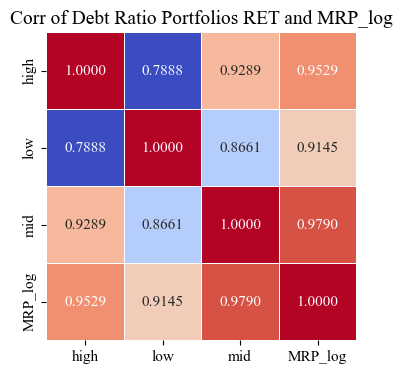

In [386]:
# Ensure 'Date' is datetime
df_dr['Date'] = pd.to_datetime(df_dr['Date'])

# Set appropriate index
df_dr.set_index(['Date', 'DR_port'], inplace=True)

# Aggregate monthly data
monthly_returns = df_dr.groupby([pd.Grouper(level='Date', freq='M'), 'DR_port']).mean()

# Prepare data for correlation calculation
monthly_returns.reset_index(inplace=True)
pivot_data = monthly_returns.pivot_table(index='Date', columns='DR_port', values='excess_return_log')
pivot_data['MRP_log'] = monthly_returns.groupby('Date')['MRP_log'].first()  # Add 'MRP' to the pivot table

# Calculate the correlation matrix
correlation_matrix = pivot_data.corr()

# Use seaborn to create a heatmap for the correlation matrix
plt.figure(figsize=(4, 4)) # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", 
            linewidths=.5, cbar=False)  # Set cbar to False to remove the color scale

plt.title('Corr of Debt Ratio Portfolios RET and MRP_log')
plt.xlabel('')  
plt.ylabel('')  
plt.show()

# Resetting the index after plotting
df_dr.reset_index(inplace=True)

In [387]:
# Initialize an empty list to store the results
results = []

# Group the DataFrame by 'DR_port' and then calculate correlations within each group
for DR_port, group in df_dr.groupby('DR_port'):
    results_row = {'DR_port': DR_port}
    for period, (start_date, end_date) in time_periods.items():
        # Filter data by time period
        period_data = group[(group['Date'] >= start_date) & (group['Date'] <= end_date)]
        if len(period_data) > 2:
            correlation, p_value = pearsonr(period_data['weighted_debt_ratio'], period_data['GS10'])
            # Append correlation and significance stars
            results_row[f'Rho {period}'] = f"{correlation:.4f}{significance_stars(p_value)}"
        else:
            results_row[f'Rho {period}'] = 'N/A'
    
    # Append the results
    results.append(results_row)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame by 'DR_port'
results_df.sort_values(by=['DR_port'], inplace=True)

# Print the text "Summary of Correlations by DR_port and Time Period"
print("Correlations between Debt Ratio and GS10 and Time Period")

# Print the results DataFrame
display(results_df.tail(50))

Correlations between Debt Ratio and GS10 and Time Period


DR_port Rho Overall Rho '71-'80 Rho '80-'90 Rho '90-'00 Rho '00-'10  \
0    high  -0.6909***   0.6857***  -0.7340***  -0.5453***     -0.0935   
1     low   0.5036***   0.8864***   0.3544***   0.6144***  -0.6920***   
2     mid  -0.3220***   0.8849***  -0.4840***   0.2359***   -0.2111**   

  Rho '10-'20 Rho '20-'24  
0  -0.3417***   0.6258***  
1  -0.5259***    0.3494**  
2  -0.3361***  -0.4517***

# Debt Ratio Sector Combination Portfolios
- The mid group outperforms the other groups measured by average.
    - However, the high group has the highest count; this indicates that the high and mid groups are fairly close.
    - The mid group also has the lowest volatility.
    - The differences described above are insignificant.

In [388]:
# delete all observation where the variable 'DR_sector_port' is ending with _nan
df_dr_sector= df_dr_sector_portfolios[~df_dr_sector_portfolios['DR_sector_port'].str.endswith('_nan')]
df_dr_sector_copy= df_dr_sector.copy()

# set data type of 'Date' column to datetime
df_dr_sector['Date'] = pd.to_datetime(df_dr_sector['Date'])
df_ind_var['Date'] = pd.to_datetime(df_ind_var['Date'])

# Merge the DataFrames
df_dr_sector = pd.merge(df_dr_sector, df_ind_var, on='Date')

# Calculate the excess return
df_dr_sector['excess_return'] = df_dr_sector['weighted_return'] - df_dr_sector['RF']

# Calculate the log of the excess return
df_dr_sector['excess_return_log']=np.log(df_dr_sector['excess_return']+1)

In [389]:
# Calculate the number of unique sectors to determine subplot grid size
DR_sector_port = df_dr_sector['DR_sector_port'].unique()

# Create the summary statistics DataFrame
summary_stats = pd.DataFrame(index=DR_sector_port)

# Calculating summary statistics for each sector
for DR_sector_port in DR_sector_port:
    dr_sector_data = df_dr_sector[df_dr_sector['DR_sector_port'] == DR_sector_port]['excess_return_log']
    summary_stats.loc[DR_sector_port, 'Mean'] = dr_sector_data.mean().round(4)
    summary_stats.loc[DR_sector_port, 'Std Dev'] = dr_sector_data.std().round(4)
    summary_stats.loc[DR_sector_port, 'Skewness'] = skew(dr_sector_data).round(4)
    summary_stats.loc[DR_sector_port, 'Kurtosis'] = kurtosis(dr_sector_data).round(4)
    summary_stats.loc[DR_sector_port, 'Min'] = dr_sector_data.min().round(4)
    summary_stats.loc[DR_sector_port, 'Max'] = dr_sector_data.max().round(4)
    jb_test_stat, jb_p_value = jarque_bera(dr_sector_data)
    summary_stats.loc[DR_sector_port, 'J-B p-Value'] = jb_p_value

# Formatting the p-value column with asterisks for significance
summary_stats['J-B p-Value'] = summary_stats['J-B p-Value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
)

# Displaying the summary statistics table
summary_stats.sort_index(inplace=True)
summary_stats.reset_index(inplace=True)
summary_stats.rename(columns={'index': 'Segment'}, inplace=True)

# Define custom sort keys
sort_order = {'_high': 1, '_mid': 2, '_low': 3}

# Function to extract sort key based on '_high', '_mid', '_low'
def custom_sort_key(segment):
    for key, rank in sort_order.items():
        if segment.endswith(key):
            return segment.replace(key, '') + f'_{rank}'

# Apply the custom sort function to create a sort column
summary_stats['SortKey'] = summary_stats['Segment'].apply(custom_sort_key)
summary_stats = summary_stats.sort_values(by='SortKey')
summary_stats = summary_stats.drop(columns=['SortKey'])

display(summary_stats)

Segment    Mean  Std Dev  Skewness  Kurtosis     Min     Max  \
0   BusEq_high  0.0038   0.0707   -0.6177    2.1273 -0.3523  0.2289   
2    BusEq_mid  0.0057   0.0730   -0.5496    1.9132 -0.3246  0.2269   
1    BusEq_low  0.0035   0.0777   -0.4373    2.1564 -0.3822  0.2493   
3   Chems_high  0.0050   0.0542   -0.4474    2.7714 -0.3169  0.2380   
5    Chems_mid  0.0048   0.0474   -0.4853    2.3948 -0.2678  0.1884   
4    Chems_low  0.0027   0.0628   -0.9723    5.0166 -0.4055  0.1960   
6   Durbl_high  0.0022   0.0745   -0.6411    4.7834 -0.4455  0.4107   
8    Durbl_mid  0.0068   0.0685    0.2358    5.1108 -0.3269  0.4176   
7    Durbl_low  0.0009   0.0732   -0.6671    5.5432 -0.4504  0.3251   
9   Enrgy_high  0.0037   0.0829   -0.9708    9.1034 -0.6963  0.3650   
11   Enrgy_mid  0.0048   0.0637   -0.7496    6.8430 -0.5006  0.2511   
10   Enrgy_low  0.0026   0.0739   -0.3910    2.6277 -0.3710  0.2573   
12   Hlth_high  0.0061   0.0540   -0.1483    2.0093 -0.2821  0.2446   
14    Hlth_mid  0.0052   0.0509   -0.3218    2.1171 -0.2211  0.2699   
13    Hlth_low  0.0031   0.0711   -0.5518    2.9504 -0.4269  0.2861   
15  Manuf_high  0.0041   0.0604   -0.8717    4.1811 -0.3841  0.2178   
17   Manuf_mid  0.0045   0.0629   -1.0723    5.1777 -0.4082  0.1951   
16   Manuf_low  0.0038   0.0639   -0.6826    2.4427 -0.3500  0.1756   
18  Money_high  0.0042   0.0635   -0.6450    2.7312 -0.2895  0.2270   
20   Money_mid  0.0044   0.0550   -0.7871    3.0124 -0.2967  0.1724   
19   Money_low  0.0041   0.0491   -0.9016    3.2598 -0.2670  0.1718   
21  NoDur_high  0.0055   0.0466   -0.5693    2.7621 -0.2403  0.1879   
23   NoDur_mid  0.0046   0.0473   -0.5703    2.3294 -0.2287  0.1679   
22   NoDur_low  0.0056   0.0510   -0.6135    4.0844 -0.3206  0.2371   
24  Other_high  0.0033   0.0637   -0.8239    3.3495 -0.3570  0.2443   
26   Other_mid  0.0047   0.0528   -0.6868    3.2219 -0.3223  0.1805   
25   Other_low  0.0020   0.0638   -0.9326    5.0317 -0.3751  0.2670   
27  Shops_high  0.0038   0.0573   -0.8633    4.6307 -0.3970  0.2211   
29   Shops_mid  0.0059   0.0532   -0.4965    2.9775 -0.3221  0.2225   
28   Shops_low  0.0051   0.0580   -0.4469    2.5916 -0.3315  0.2450   
30  Telcm_high  0.0041   0.0645   -1.0877    4.9804 -0.3693  0.2123   
32   Telcm_mid  0.0038   0.0516   -0.5028    1.2932 -0.1836  0.2260   
31   Telcm_low  0.0030   0.0665   -0.5689    2.3967 -0.3135  0.2565   
33  Utils_high  0.0046   0.0460   -0.4103    2.1712 -0.1796  0.2249   
35   Utils_mid  0.0030   0.0462   -0.0394    2.5743 -0.1533  0.2773   
34   Utils_low  0.0044   0.0471   -0.1498    3.8086 -0.2461  0.2738   

   J-B p-Value  
0          ***  
2          ***  
1          ***  
3          ***  
5          ***  
4          ***  
6          ***  
8          ***  
7          ***  
9          ***  
11         ***  
10         ***  
12         ***  
14         ***  
13         ***  
15         ***  
17         ***  
16         ***  
18         ***  
20         ***  
19         ***  
21         ***  
23         ***  
22         ***  
24         ***  
26         ***  
25         ***  
27         ***  
29         ***  
28         ***  
30         ***  
32         ***  
31         ***  
33         ***  
35         ***  
34         ***

In [390]:
# Create a new column 'DR' that takes the value 'high', 'mid', or 'low' if the 'DR_sector_port' column ends with '_high', '_mid', or '_low' respectively
df_dr_sector_copy['DR'] = df_dr_sector_copy['DR_sector_port'].str.split('_').str[-1]

# Create a new df that take the average of 'weighted_return' for each 'Date' and 'DR' combination
df_dr_sector_avg = df_dr_sector_copy.groupby(['Date', 'DR'])['weighted_return'].mean().reset_index()

# Merge the new df with df_ind_var on 'Date'
df_dr_sector_avg = pd.merge(df_dr_sector_avg, df_ind_var, on='Date')

# Calculate the excess return
df_dr_sector_avg['excess_return'] = df_dr_sector_avg['weighted_return'] - df_dr_sector_avg['RF']
df_dr_sector_avg['excess_return_log']=np.log(df_dr_sector_avg['excess_return']+1)

df_dr_sector_avg['MRP_log']=np.log(df_dr_sector_avg['MRP']+1)

I have used the average of the grouped calculated above, there is a difference between this and the one calculated below because some DR_sector_port has missing values

In [391]:
# Calculate the number of unique sectors to determine subplot grid size
DR_ports = df_dr_sector_avg['DR'].unique()

# Create the summary statistics DataFrame
summary_stats = pd.DataFrame(index=DR_ports)

# Calculating summary statistics for each sector
for DR_port in DR_ports:
    dr_data = df_dr_sector_avg[df_dr_sector_avg['DR'] == DR_port]['excess_return_log']
    summary_stats.loc[DR_port, 'Mean'] = dr_data.mean().round(4)
    summary_stats.loc[DR_port, 'Std Dev'] = dr_data.std().round(4)
    summary_stats.loc[DR_port, 'Skewness'] = skew(dr_data).round(4)
    summary_stats.loc[DR_port, 'Kurtosis'] = kurtosis(dr_data).round(4)
    summary_stats.loc[DR_port, 'Min'] = dr_data.min().round(4)
    summary_stats.loc[DR_port, 'Max'] = dr_data.max().round(4)
    jb_test_stat, jb_p_value = jarque_bera(dr_data)
    summary_stats.loc[DR_port, 'J-B p-Value'] = jb_p_value

# Formatting the p-value column with asterisks for significance
summary_stats['J-B p-Value'] = summary_stats['J-B p-Value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
)

# Displaying the summary statistics table
summary_stats.sort_index(inplace=True)
summary_stats.reset_index(inplace=True)
summary_stats.rename(columns={'index': 'Debt ratio'}, inplace=True)

# sort the table by the 'Debt ratio' column in the order high, mid, low
summary_stats['Debt ratio'] = pd.Categorical(summary_stats['Debt ratio'], ['high', 'mid', 'low'])
summary_stats.sort_values('Debt ratio', inplace=True)

display(summary_stats)

# Pivot the data to get 'weighted_return' for each 'DR_port' across 'Date'
pivoted_data = df_dr.pivot_table(index='Date', columns='DR_port', values='weighted_return')

# Calculate the correlation matrix across different 'DR_port'
correlation_matrix = pivoted_data.corr().round(4)

# Display the correlation matrix
display(correlation_matrix)

Debt ratio    Mean  Std Dev  Skewness  Kurtosis     Min     Max J-B p-Value
0       high  0.0049   0.0498   -0.9425    4.2800 -0.3094  0.1662         ***
2        mid  0.0055   0.0447   -0.6609    2.6388 -0.2397  0.1511         ***
1        low  0.0042   0.0500   -0.7448    2.6621 -0.2833  0.1507         ***

DR_port    high     low     mid
DR_port                        
high     1.0000  0.7845  0.9276
low      0.7845  1.0000  0.8619
mid      0.9276  0.8619  1.0000

In [392]:
# Group by 'sector' and calculate mean and standard deviation
DR_stats = df_dr_sector_avg.groupby('DR')['excess_return_log'].agg(['mean', 'std', 'count','min','max'])

display(DR_stats)

mean       std  count       min       max
DR                                                 
high  0.004900  0.049815    636 -0.309366  0.166233
low   0.004172  0.049992    636 -0.283254  0.150700
mid   0.005453  0.044742    636 -0.239679  0.151127

# Regressions: CAPM extended with the different interst rates
- The longer the rate, the higher the significance of the interest rate coefficients.
    - Additionally, the magnitude of the coefficients is higher.
- The QQ-plots show that the residuals are not normally distributed, violating the Gauss-Markov assumption.
- The constants are mostly significant, with a few exceptions.
- The magnitude of the GS10 coefficients varies across sectors.
    - Some are significantly different from zero, while others are not.
- All MRP coefficients are significant. They vary in being above or below 1, indicating higher or lower risk compared to MRP.

In [393]:
def run_ols_and_store_results(df_sector, segment, results_df, interest_var):
    # Filter data for the specific sector
    segment_df = df_sector[df_sector['sector'] == segment]
    
    # Prepare independent variables with a constant added
    X = segment_df[['MRP_log', interest_var]]
    X = sm.add_constant(X)
    
    # Dependent variable
    y = segment_df['excess_return_log']
    
    # Fit OLS model
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})

    # Coefficient and significance for the interest variable
    coef_value_interest = model.params[interest_var].round(4)
    coef_significance_interest = significance_stars(model.pvalues[interest_var])
    
    # Coefficient and significance for the MRP_log variable
    coef_value_mrp = model.params['MRP_log'].round(4)
    coef_significance_mrp = significance_stars(model.pvalues['MRP_log'])
    
    # R-squared value, rounded to 3 decimal places
    r_squared = model.rsquared_adj.round(4)

    # Create a temporary DataFrame to store results
    temp_df = pd.DataFrame({
        'Segment': [segment],
        'Model': [interest_var.split('_')[0]],  # Assumes naming convention like 'GS10_diff'
        'Interest_Coef': [f"{coef_value_interest}{coef_significance_interest}"],
        'MRP_log_Coef': [f"{coef_value_mrp}{coef_significance_mrp}"],
        'R_square': [f"{r_squared}"]
    })

    # Concatenate the new results with the existing DataFrame
    return pd.concat([results_df, temp_df], ignore_index=True)

# Define the interest variables and segments
interest_vars = ['fedfunds_diff', 'GS1_diff', 'GS5_diff', 'GS10_diff']
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
results_df = pd.DataFrame(columns=['Segment', 'Model', 'Interest_Coef', 'MRP_log_Coef', 'R_square'])

# Loop through segments and interest variables to fit models and store results
for segment in segments:
    for interest_var in interest_vars:
        results_df = run_ols_and_store_results(df_sector, segment, results_df, interest_var)

# Pivot the DataFrame
pivot_df = results_df.pivot_table(index='Segment', columns='Model', values=['Interest_Coef', 'MRP_log_Coef', 'R_square'], aggfunc='first')

# Define the column order
models = ['fedfunds', 'GS1', 'GS5', 'GS10']
new_columns = [(coef, model) for model in models for coef in ['MRP_log_Coef', 'Interest_Coef', 'R_square']]

# Reorder the columns using the specified new order
pivot_df = pivot_df[new_columns]

# Display the reorganized DataFrame
display(pivot_df)


MRP_log_Coef Interest_Coef R_square MRP_log_Coef Interest_Coef  \
Model       fedfunds      fedfunds fedfunds          GS1           GS1   
Segment                                                                  
BusEq      1.2545***        0.0028   0.7421    1.2649***     0.0099***   
Chems      0.8661***     -0.0034**   0.7159    0.8649***     -0.0041**   
Durbl       1.245***         0.001   0.6492    1.2536***      0.0069**   
Enrgy       0.901***       0.0066*   0.4206    0.9067***       0.0102*   
Hlth       0.8147***        0.0012   0.6037    0.8111***       -0.0013   
Manuf      1.1612***        0.0011   0.8397    1.1669***       0.005**   
Money      1.0497***        0.0002   0.7732    1.0427***     -0.0048**   
NoDur      0.7553***    -0.0043***   0.6507    0.7501***    -0.0077***   
Other      1.0985***       -0.0017   0.9073    1.0998***       -0.0008   
Shops      0.9962***    -0.0051***   0.7751    0.9958***      -0.005**   
Telcm      0.9324***       -0.0006   0.7146     0.927***      -0.0043*   
Utils       0.547***      -0.0044*   0.3608    0.5346***    -0.0128***   

        R_square MRP_log_Coef Interest_Coef R_square MRP_log_Coef  \
Model        GS1          GS5           GS5      GS5         GS10   
Segment                                                             
BusEq     0.7457     1.265***     0.0146***   0.7469    1.2639***   
Chems     0.7158    0.8655***     -0.0053**   0.7158    0.8664***   
Durbl     0.6509    1.2539***      0.0105**   0.6516    1.2514***   
Enrgy     0.4223    0.9105***      0.0188**   0.4273    0.9143***   
Hlth      0.6037    0.8072***       -0.006*   0.6053    0.8049***   
Manuf     0.8409    1.1673***     0.0077***   0.8415    1.1671***   
Money     0.7745    1.0414***    -0.0083***   0.7757    1.0409***   
NoDur     0.6537    0.7507***    -0.0106***   0.6546    0.7513***   
Other     0.9071       1.1***       -0.0009    0.907    1.1005***   
Shops     0.7742    0.9967***     -0.0064**   0.7742    0.9957***   
Telcm     0.7159    0.9254***     -0.008***   0.7173    0.9252***   
Utils     0.3745    0.5312***    -0.0222***    0.388    0.5326***   

        Interest_Coef R_square  
Model            GS10     GS10  
Segment                         
BusEq        0.016***   0.7465  
Chems         -0.0053   0.7155  
Durbl         0.0094*   0.6506  
Enrgy       0.0269***   0.4326  
Hlth        -0.0098**   0.6071  
Manuf        0.009***   0.8416  
Money       -0.0104**   0.7761  
NoDur      -0.0118***   0.6542  
Other         -0.0005    0.907  
Shops       -0.0087**   0.7748  
Telcm      -0.0097***   0.7176  
Utils      -0.0246***   0.3859

Segment   Constant MRP_log Coef   GS10 Coef  R-Squared  Residuals Skew  \
0    BusEq    -0.0016    1.2639***    0.016***     0.7465         -0.0770   
1    Chems     0.0004    0.8664***     -0.0053     0.7155         -0.2958   
2    Durbl    -0.0025    1.2514***     0.0094*     0.6506          0.2777   
3    Enrgy     0.0001    0.9143***   0.0269***     0.4326         -0.1525   
4     Hlth      0.001    0.8049***   -0.0098**     0.6071         -0.2638   
5    Manuf    -0.0015    1.1671***    0.009***     0.8416         -0.0463   
6    Money    -0.0008    1.0409***   -0.0104**     0.7761         -0.4255   
7    NoDur     0.0016    0.7513***  -0.0118***     0.6542          0.0255   
8    Other  -0.0016**    1.1005***     -0.0005     0.9070          0.0601   
9    Shops     0.0005    0.9957***   -0.0087**     0.7748          0.0066   
10   Telcm     -0.001    0.9252***  -0.0097***     0.7176         -0.2048   
11   Utils     0.0014    0.5326***  -0.0246***     0.3859         -0.0015   

    Residuals Kurtosis Breusch-Pagan p  VIF Max  Durbin-Watson  \
0               2.9494         0.0568*   1.0173       2.052319   
1               3.9040          0.2726   1.0173       1.965403   
2               5.5773          0.1023   1.0173       1.923117   
3               3.4272        0.0378**   1.0173       1.899680   
4               2.0107          0.9757   1.0173       2.091697   
5               2.2823       0.0007***   1.0173       1.822659   
6               2.8975       0.0021***   1.0173       1.888788   
7               3.2744         0.0999*   1.0173       1.863908   
8               0.6423       0.0002***   1.0173       2.079762   
9               1.2665          0.2139   1.0173       1.842367   
10              2.6561          0.5763   1.0173       1.838032   
11              1.4150       0.0093***   1.0173       1.963287   

   Breusch-Godfrey p  
0             0.5459  
1             0.7062  
2             0.3734  
3             0.4183  
4             0.2788  
5            0.027**  
6             0.2952  
7             0.086*  
8             0.4216  
9            0.0833*  
10           0.0764*  
11               1.0

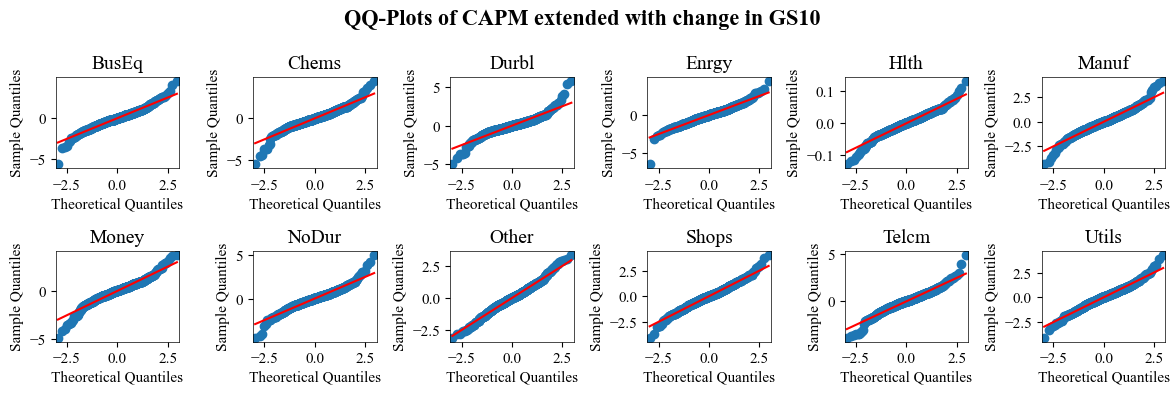

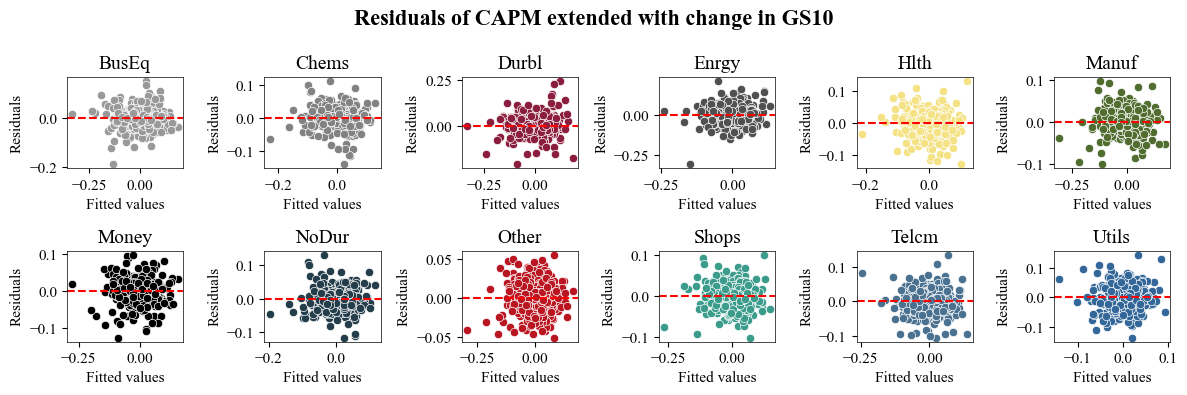

In [394]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Segment', 'Constant', 'MRP_log Coef', 'GS10 Coef', 'R-Squared', 'Residuals Skew', 'Residuals Kurtosis', 'Breusch-Pagan p', 'VIF Max','Durbin-Watson','Breusch-Godfrey p'])

def run_ols_and_store_results(df_sector, segment, results_df, axes_qq, axes_res, index):
    segment_df = df_sector[df_sector['sector'] == segment]
    X = segment_df[['MRP_log', 'GS10_diff']]
    X = sm.add_constant(X)
    y = segment_df['excess_return_log']
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    _, bp_pvalue, _, _ = het_breuschpagan(model.resid, model.model.exog)

    # Durbin-Watson test
    dw = durbin_watson(model.resid)
    
    # Breusch-Godfrey test for higher-order autocorrelation
    _, pvalue_bg, _, _ = acorr_breusch_godfrey(model, nlags=1)

    temp_df = pd.DataFrame({
        'Segment': [segment],
        'Constant': [f"{model.params['const'].round(4)}{significance_stars(model.pvalues['const'])}"],
        'MRP_log Coef': [f"{model.params['MRP_log'].round(4)}{significance_stars(model.pvalues['MRP_log'])}"],
        'GS10 Coef': [f"{model.params['GS10_diff'].round(4)}{significance_stars(model.pvalues['GS10_diff'])}"],
        'R-Squared': [model.rsquared_adj.round(4)],
        'Residuals Skew': [model.resid.skew().round(4)],
        'Residuals Kurtosis': [model.resid.kurt().round(4)],
        'Breusch-Pagan p': [f"{bp_pvalue.round(4)}{significance_stars(bp_pvalue)}"],
        'VIF Max': [vif_data["VIF"].max().round(4)],
        'Durbin-Watson': [dw],
        'Breusch-Godfrey p': [f"{pvalue_bg.round(4)}{significance_stars(pvalue_bg)}"]
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes_res[index], color=color_palette_sector.get(segment, 'grey'))
    axes_res[index].axhline(0, color='red', linestyle='dashed')
    axes_res[index].set_xlabel('Fitted values')
    axes_res[index].set_ylabel('Residuals')
    axes_res[index].set_title(f'{segment}')

    sm.qqplot(model.resid, line ='s', fit=True, ax=axes_qq[index])
    axes_qq[index].set_title(f'{segment}')

    return results_df


# Assuming 'df_sector' is your main DataFrame containing all data including the 'sector' column
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
n_segments = len(segments)

# Determine the number of rows and columns for the subplot grid
n_cols = 6
n_rows = int(np.ceil(n_segments / n_cols))

# Create a figure and a grid of subplots for both QQ plots and residual plots
fig_qq, axes_qq = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))
fig_res, axes_res = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))

# Flatten the axes array for easy indexing
axes_qq = axes_qq.flatten()
axes_res = axes_res.flatten()

for index, segment in enumerate(segments):
    results_df = run_ols_and_store_results(df_sector, segment, results_df, axes_qq, axes_res, index)

# Hide any unused subplots if the number of segments is less than the number of subplot slots
for i in range(n_segments, n_rows * n_cols):
    axes_qq[i].set_visible(False)
    axes_res[i].set_visible(False)

# Display the results DataFrame
results_df = results_df.dropna()
results_df = results_df.sort_values(by='Segment', ascending=True) 
display(results_df.head(50))

fig_qq.suptitle('QQ-Plots of CAPM extended with change in GS10', fontsize=16, fontweight='bold')
fig_res.suptitle('Residuals of CAPM extended with change in GS10', fontsize=16, fontweight='bold')

# Adjust the layout
fig_qq.tight_layout()
fig_res.tight_layout()
plt.show()

# Regressions: Fama-French 5 factor extended with GS10
- By extending the regression to include Fama-French factors, the model's R-squared substantially increases.
- The residuals' kurtosis becomes lower.
- The residuals' skewness remains unchanged or perhaps increases slightly.
- The Breusch-Pagan p-value generally decreases, however, not strictly for all sectors.
- The maximum VIF increases but remains at a reasonable level.
- GS10 coefficients become only slightly less significant.
- Alphas become only slightly less significant.
- MRP coefficients change slightly.
    - For some sectors, it increases, while for others, it decreases.


Segment    Constant MRP_log Coef   SMB Coef    HML Coef    RMW Coef  \
0    BusEq    0.0027**    1.0963***     0.0004  -0.0037***  -0.0043***   
1    Chems  -0.0027***    0.9773***    -0.0002     -0.0004   0.0047***   
2    Durbl   -0.0035**    1.2241***  0.0029***   0.0034***      0.0006   
3    Enrgy     -0.0031    1.0398***    -0.0001    0.0038**      0.002*   
4     Hlth      0.0005    0.8506***  -0.0012**  -0.0043***     0.002**   
5    Manuf  -0.0037***    1.1853***  0.0028***   0.0015***   0.0026***   
6    Money    -0.002**    1.0884***    -0.0002   0.0063***      0.0002   
7    NoDur    -0.0017*    0.8608***     0.0004     -0.0005   0.0056***   
8    Other  -0.0021***    1.0958***  0.0012***      0.0004      0.0007   
9    Shops     -0.0009    0.9879***  0.0023***     -0.0008   0.0043***   
10   Telcm     -0.0007     0.946***   -0.0012*      0.0002    -0.0016*   
11   Utils     -0.0008    0.6513***  -0.0015**     0.0015*     0.0012*   

      CMA Coef   GS10 Coef  R-Squared  Residuals Skew  Residuals Kurtosis  \
0    -0.004***   0.0143***     0.8382         -0.0619              0.6728   
1     0.004***     -0.0032     0.7845         -0.5836              5.1356   
2      -0.0019       0.007     0.6772          0.2817              5.7461   
3      0.0032*   0.0276***     0.5010         -0.0767              1.7241   
4     0.004***   -0.0076**     0.6605         -0.1002              1.3112   
5     0.0013**   0.0078***     0.8769         -0.4943              2.4998   
6   -0.0028***   -0.011***     0.8599          0.1359              1.7885   
7    0.0041***   -0.0099**     0.7514         -0.0507              2.3050   
8       0.0002     -0.0011     0.9111          0.0918              0.6435   
9      -0.0001   -0.0089**     0.8069          0.1107              0.5378   
10      0.0009   -0.0093**     0.7235         -0.2193              2.3733   
11   0.0037***  -0.0229***     0.4618          0.0342              1.0392   

   Breusch-Pagan p  VIF Max  
0         0.0304**   2.0942  
1           0.0***   2.0942  
2         0.0142**   2.0942  
3          0.0796*   2.0942  
4           0.1711   2.0942  
5         0.0294**   2.0942  
6         0.0132**   2.0942  
7           0.2643   2.0942  
8         0.0321**   2.0942  
9           0.3655   2.0942  
10          0.7051   2.0942  
11         0.0502*   2.0942

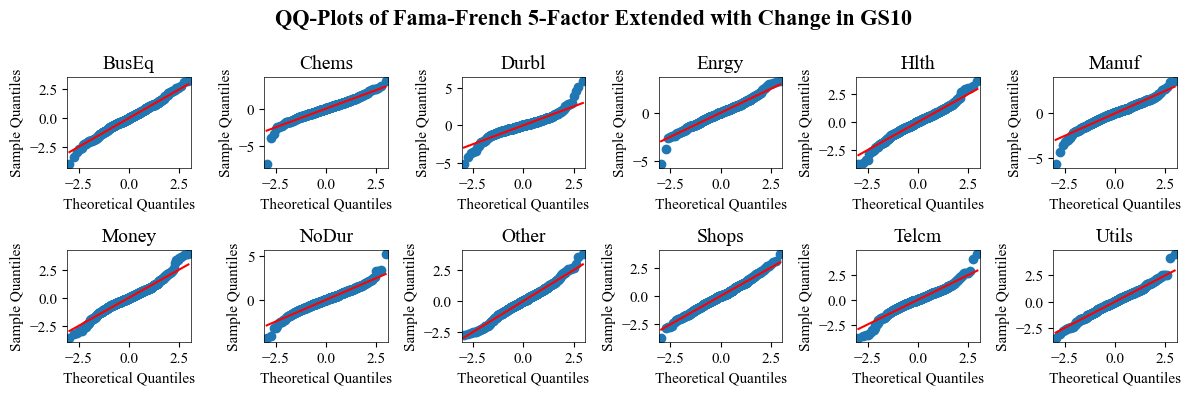

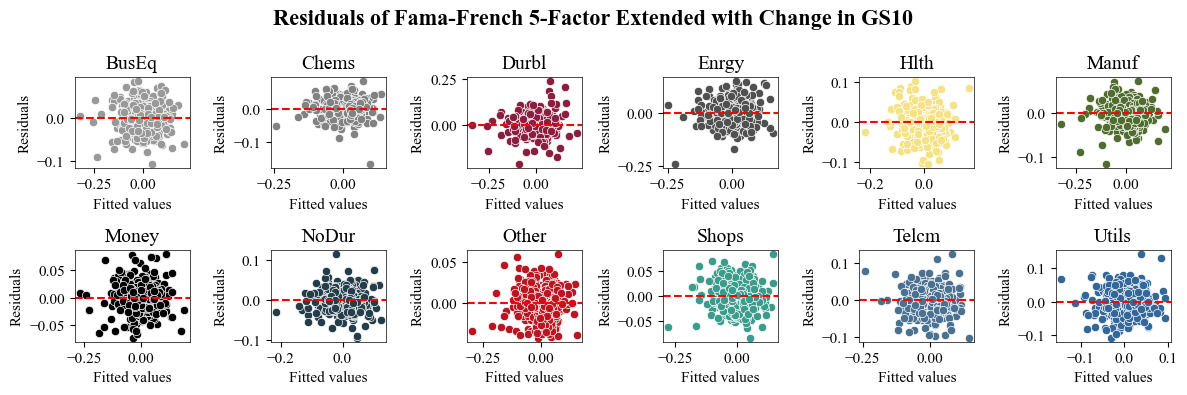

In [395]:
# Initialize DataFrame
results_df = pd.DataFrame(columns=['Segment', 'Constant', 'MRP_log Coef', 'SMB Coef', 'HML Coef', 'RMW Coef', 'CMA Coef', 'GS10 Coef', 'R-Squared', 'Residuals Skew', 'Residuals Kurtosis', 'Breusch-Pagan p', 'VIF Max'])

def run_ols_and_store_results(df_sector, segment, results_df, axes_qq, axes_res, index):
    segment_df = df_sector[df_sector['sector'] == segment]
    X = segment_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']]
    X = sm.add_constant(X)
    y = segment_df['excess_return_log']
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    _, bp_pvalue, _, _ = het_breuschpagan(model.resid, model.model.exog)
    
    temp_df = pd.DataFrame({
        'Segment': [segment],
        'Constant': [f"{model.params['const'].round(4)}{significance_stars(model.pvalues['const'])}"],
        'MRP_log Coef': [f"{model.params['MRP_log'].round(4)}{significance_stars(model.pvalues['MRP_log'])}"],
        'SMB Coef': [f"{model.params['SMB'].round(4)}{significance_stars(model.pvalues['SMB'])}"],
        'HML Coef': [f"{model.params['HML'].round(4)}{significance_stars(model.pvalues['HML'])}"],
        'RMW Coef': [f"{model.params['RMW'].round(4)}{significance_stars(model.pvalues['RMW'])}"],
        'CMA Coef': [f"{model.params['CMA'].round(4)}{significance_stars(model.pvalues['CMA'])}"],
        'GS10 Coef': [f"{model.params['GS10_diff'].round(4)}{significance_stars(model.pvalues['GS10_diff'])}"],
        'R-Squared': [model.rsquared_adj.round(4)],
        'Residuals Skew': [model.resid.skew().round(4)],
        'Residuals Kurtosis': [model.resid.kurt().round(4)],
        'Breusch-Pagan p': [f"{bp_pvalue.round(4)}{significance_stars(bp_pvalue)}"],
        'VIF Max': [vif_data["VIF"].max().round(4)]
    })
    
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes_res[index], color=color_palette_sector.get(segment, 'grey'))
    axes_res[index].axhline(0, color='red', linestyle='dashed')
    axes_res[index].set_xlabel('Fitted values')
    axes_res[index].set_ylabel('Residuals')
    axes_res[index].set_title(f'{segment}')
    sm.qqplot(model.resid, line='s', fit=True, ax=axes_qq[index])
    axes_qq[index].set_title(f'{segment}')
    return results_df

segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
n_segments = len(segments)
n_cols = 6
n_rows = int(np.ceil(n_segments / n_cols))
fig_qq, axes_qq = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))
fig_res, axes_res = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))
axes_qq = axes_qq.flatten()
axes_res = axes_res.flatten()

for index, segment in enumerate(segments):
    results_df = run_ols_and_store_results(df_sector, segment, results_df, axes_qq, axes_res, index)

for i in range(n_segments, n_rows * n_cols):
    axes_qq[i].set_visible(False)
    axes_res[i].set_visible(False)

results_df = results_df.dropna()
results_df = results_df.sort_values(by='Segment', ascending=True)
display(results_df.head(50))

fig_qq.suptitle('QQ-Plots of Fama-French 5-Factor Extended with Change in GS10', fontsize=16, fontweight='bold')
fig_res.suptitle('Residuals of Fama-French 5-Factor Extended with Change in GS10', fontsize=16, fontweight='bold')

fig_qq.tight_layout()
fig_res.tight_layout()
plt.show()

In [396]:
def run_ols_and_store_results(df_sector, segment, time_periods):
    results = {}
    for period, (start_date, end_date) in time_periods.items():
        period_df = df_sector[(df_sector['Date'] >= start_date) & (df_sector['Date'] <= end_date) & (df_sector['sector'] == segment)]
        if not period_df.empty:
            X = period_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']]
            X = sm.add_constant(X)
            y = period_df['excess_return_log']
            model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
            results[period] = f"{model.params['GS10_diff'].round(4)}{significance_stars(model.pvalues['GS10_diff'])}"
        else:
            results[period] = 'n/a'  # No data available for this period and segment

    return results

# Assuming df_sector is defined and includes the necessary columns
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
final_results = {}

for segment in segments:
    final_results[segment] = run_ols_and_store_results(df_sector, segment, time_periods)

# Convert the results dictionary to a DataFrame and pivot it
results_df = pd.DataFrame.from_dict(final_results, orient='index')
results_df.columns = list(time_periods.keys())  # Naming columns after the periods

display(results_df)


Overall     '71-'80     '80-'90     '90-'00  '00-'10     '10-'20  \
BusEq   0.0143***      0.0075     0.0087*      0.0054    0.007      0.0121   
Chems     -0.0032      0.0063     -0.0041      0.0107   0.0141  -0.0343***   
Durbl       0.007     -0.0124      0.0021      0.0145    0.012     -0.0089   
Enrgy   0.0276***      0.0189    0.0207**      -0.004   0.0252     -0.0225   
Hlth    -0.0076**     -0.0078     -0.0073     -0.0048  -0.0093    -0.0218*   
Manuf   0.0078***   0.0243***      0.0039      0.0075    0.013     -0.0122   
Money   -0.011***  -0.0235***  -0.0143***      0.0025  -0.0041      0.0019   
NoDur   -0.0099**     -0.0074    -0.0105*      0.0072   0.0095     -0.0072   
Other     -0.0011      0.0052      -0.001       0.006   0.0001    -0.015**   
Shops   -0.0089**     -0.0065      -0.008      0.0069   0.0034     -0.0002   
Telcm   -0.0093**   -0.0236**   -0.0149**   -0.0187**  -0.0009     -0.0075   
Utils  -0.0229***     -0.0185  -0.0152***  -0.0385***   0.0056  -0.0468***   

         '20-'24  
BusEq    -0.0102  
Chems    -0.0117  
Durbl  0.1059***  
Enrgy   0.118***  
Hlth     -0.0076  
Manuf    -0.0053  
Money    -0.0004  
NoDur     0.0092  
Other    -0.0055  
Shops    -0.0089  
Telcm    -0.0129  
Utils    -0.0001

# Rolling regression: CAPM extended with GS10
- Rolling regression substantially increases the R-squared of the models.
- The sector intercorrelation with the GS10 coefficient is generally weak, with a few exceptions.
    - This indicates that the GS10 coefficient is not dependent on time, as this would be measured by their co-movement.
- There are quite large movements in the magnitude of the GS10 coefficients across the investigation period, indicating that the results are not the most robust.
- There is a weak correlation between GS10 coefficient and Debt Ratios within sectors (see the large correlation heatmap)

In [397]:
def run_rolling_ols_and_store_results(df_sector, segment, window_size=60):
    segment_df = df_sector[df_sector['sector'] == segment]
    rolling_coefficients = []
    rolling_dates = []
    rolling_r_squared = []

    if len(segment_df) < window_size:
        return [], [], []

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
        rolling_coefficients.append(model.params)
        rolling_dates.append(segment_df['Date'].iloc[end - 1])
        rolling_r_squared.append(model.rsquared_adj.round(4))

    return rolling_dates, rolling_coefficients, rolling_r_squared

# Assuming df_sector is your input DataFrame
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
coefficients_data = {}
r_squared_data = {}

for segment in segments:
    dates, coeffs, r_squared = run_rolling_ols_and_store_results(df_sector, segment)
    if dates:
        # Convert list of Series to DataFrame and then compute mean for each coefficient
        coeffs_df = pd.DataFrame(coeffs)
        mean_coeffs = coeffs_df.mean().to_dict()  # Get mean of each coefficient
        coefficients_data[segment] = mean_coeffs
        r_squared_data[segment] = np.mean(r_squared)

# Create DataFrame to display average coefficients and R-squared values
coefficients_summary = pd.DataFrame(coefficients_data).T  # Transpose to switch rows and columns
r_squared_values = pd.Series(r_squared_data, name='Average R-Squared')

# Join R-squared values to the coefficients summary DataFrame
summary_df = coefficients_summary.join(r_squared_values)

display(summary_df)

const   MRP_log  GS10_diff  Average R-Squared
BusEq -0.001455  1.281646   0.012444           0.774877
Chems  0.000009  0.886909  -0.000893           0.729118
Durbl -0.002246  1.195322   0.005679           0.698855
Enrgy -0.000957  0.913429   0.022675           0.461417
Hlth   0.000299  0.853359  -0.010578           0.614724
Manuf -0.001603  1.165452   0.011693           0.841161
Money -0.000583  1.034353  -0.002181           0.798741
NoDur  0.001934  0.758689  -0.006833           0.664474
Other -0.001667  1.094140   0.001005           0.896669
Shops  0.000704  0.996234  -0.003001           0.763053
Telcm -0.000039  0.906124  -0.013283           0.727882
Utils  0.002353  0.490573  -0.030447           0.409848

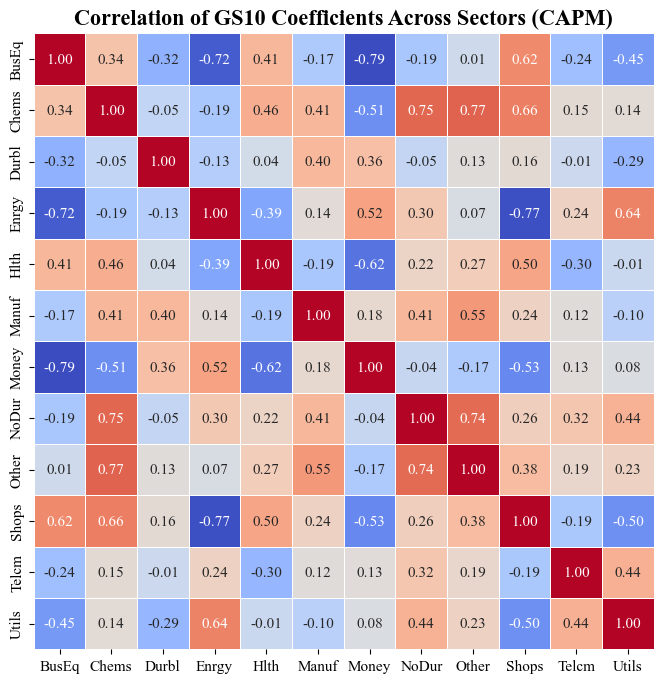

In [398]:
def run_rolling_ols_and_store_results(df_sector, segment, window_size=60):
    segment_df = df_sector[df_sector['sector'] == segment]
    rolling_results = []
    rolling_dates = []
    rolling_r_squared = []

    if len(segment_df) < window_size:
        return [], [], []  # Return empty lists if there aren't enough data

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
        rolling_results.append(model.params.get('GS10_diff', 0))  # Handle potential missing coefficients
        rolling_dates.append(segment_df['Date'].iloc[end - 1])
        rolling_r_squared.append(model.rsquared_adj.round(4))

    return rolling_dates, rolling_results, rolling_r_squared

# Assuming df_sector is your input DataFrame
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
coefficients_data = {}
r_squared_data = {}

for segment in segments:
    dates, coeffs, r_squared = run_rolling_ols_and_store_results(df_sector, segment)
    if dates:  # Check if dates list is not empty
        coefficients_data[segment] = pd.Series(coeffs, index=dates)
        r_squared_data[segment] = pd.Series(r_squared, index=dates)

coefficients_df = pd.DataFrame(coefficients_data)
r_squared_values = pd.DataFrame(r_squared_data)

coefficients_df.dropna(how='any', inplace=True)
r_squared_values.dropna(how='any', inplace=True)

# Compute the correlation matrix and plot it
correlation_matrix = coefficients_df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
plt.title('Correlation of GS10 Coefficients Across Sectors (CAPM)', fontweight='bold', fontsize=16)
plt.show()

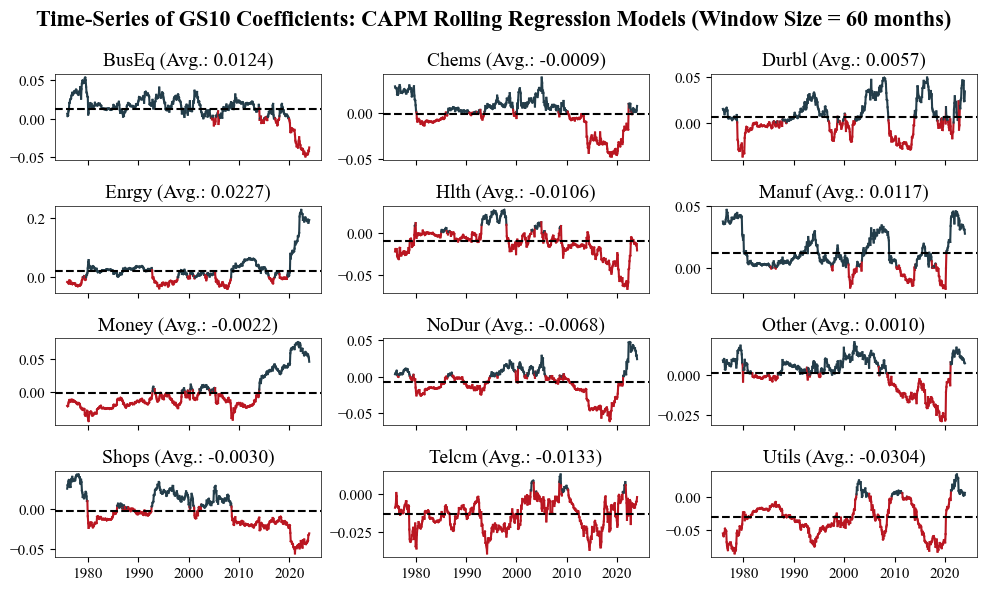

In [399]:
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 6), sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each sector's coefficients and the mean line
for i, column in enumerate(coefficients_df.columns):
    y = coefficients_df[column]
    x = coefficients_df.index
    
    # Plot each segment with different colors based on value
    for j in range(1, len(y)):
        if y.iloc[j-1] < 0 or y.iloc[j] < 0:
            color = '#BA1621'
        else:
            color = '#233D4A' 
        # Plot segment
        axes[i].plot(x[j-1:j+1], y.iloc[j-1:j+1], color=color)
    
    # Calculate and plot the mean line
    mean_value = y.mean()
    axes[i].axhline(y=mean_value, color='black', linestyle='--', label='Average Coefficient')
    
    # Setting titles and labels
    title_with_mean = f'{column} (Avg.: {mean_value:.4f})'
    axes[i].set_title(title_with_mean)
    axes[i].tick_params(axis='x')

# Set the main title for all subplots
fig.suptitle('Time-Series of GS10 Coefficients: CAPM Rolling Regression Models (Window Size = 60 months)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

Segment  Constant  MRP_log Coef  GS10 Coef  R-Squared  Residuals Skew  \
0    BusEq -0.001455      1.281646   0.012444   0.774877        0.116433   
1    Chems  0.000009      0.886909  -0.000893   0.729118       -0.172822   
2    Durbl -0.002246      1.195322   0.005679   0.698855        0.297342   
3    Enrgy -0.000957      0.913429   0.022675   0.461417        0.181496   
4     Hlth  0.000299      0.853359  -0.010578   0.614724       -0.371551   
5    Manuf -0.001603      1.165452   0.011693   0.841161       -0.061886   
6    Money -0.000583      1.034353  -0.002181   0.798741       -0.117862   
7    NoDur  0.001934      0.758689  -0.006833   0.664474       -0.214924   
8    Other -0.001667      1.094140   0.001005   0.896669        0.009300   
9    Shops  0.000704      0.996234  -0.003001   0.763053       -0.055334   
10   Telcm -0.000039      0.906124  -0.013283   0.727882        0.013272   
11   Utils  0.002353      0.490573  -0.030447   0.409848       -0.206272   

    Residuals Kurtosis  Breusch-Pagan p  
0             1.623153     1.903404e-16  
1             3.941490     1.335108e-30  
2             4.034843     2.338010e-37  
3             0.946765     3.041537e-09  
4             1.858750     5.202350e-06  
5             1.758072    2.500045e-119  
6             2.680626     9.168654e-86  
7             2.365885     2.061987e-34  
8             0.821904    3.346266e-117  
9             0.690356     2.140382e-18  
10            2.254662     1.054611e-01  
11            0.728336     5.502432e-59

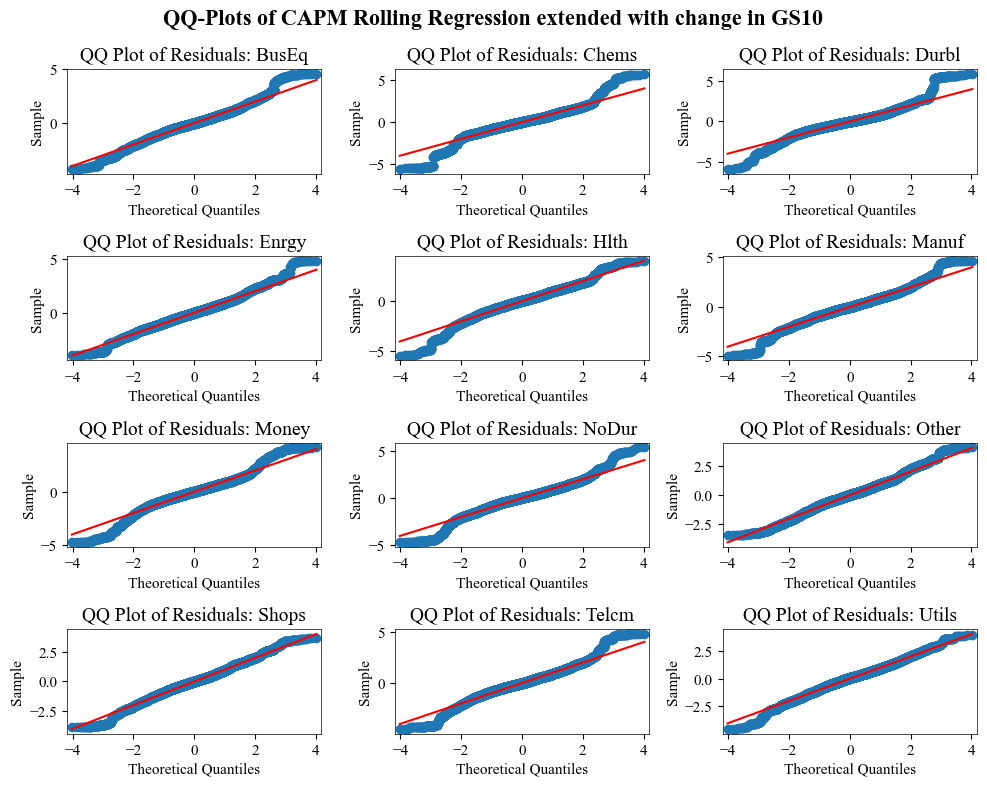

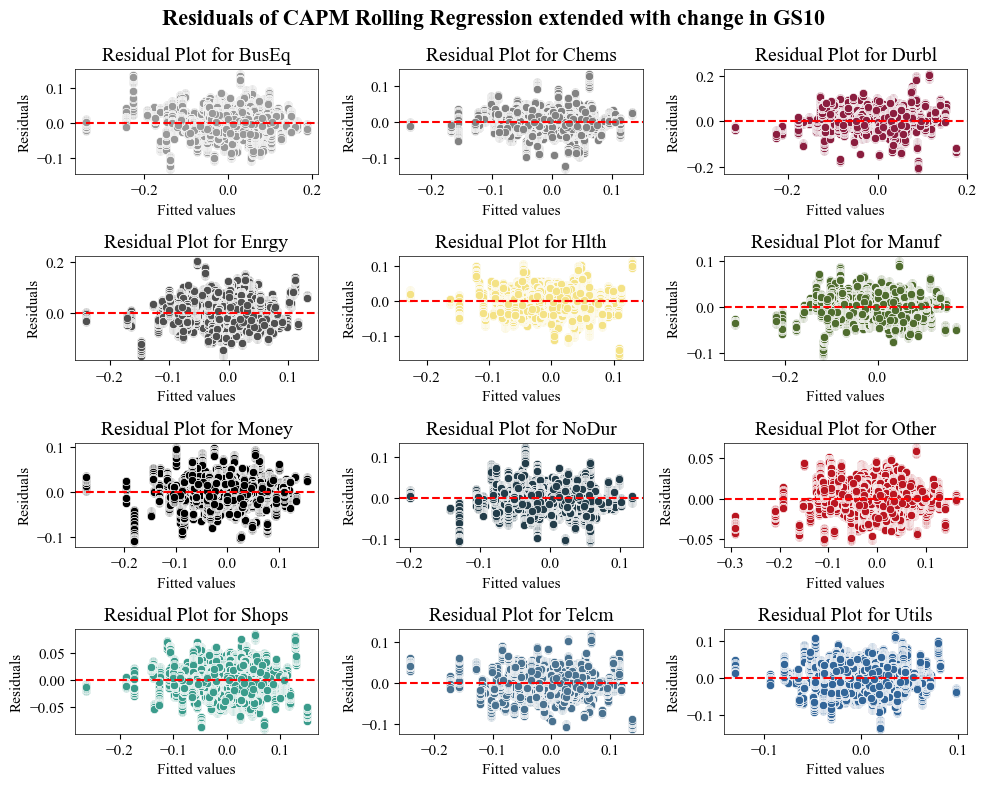

In [400]:
def run_rolling_ols_and_store_results(df_sector, segment, results_df, axes_qq, axes_res, index, window_size=60):
    segment_df = df_sector[df_sector['sector'] == segment]
    rolling_results = []
    all_residuals = []  # List to store residuals from all models
    exog_list = []  # Store exogenous variables for each model to match residuals
    rolling_r_squared = []

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})

        rolling_results.append(model.params)
        rolling_r_squared.append(model.rsquared_adj.round(4))
        all_residuals.extend(model.resid)  # Store residuals from each model
        exog_list.append(X)  # Store corresponding exogenous variables

    # Concatenate all exogenous variable dataframes
    full_exog = pd.concat(exog_list, ignore_index=True)

    # Averaging model parameters
    avg_params = pd.DataFrame(rolling_results).mean().to_dict()
    avg_rsq = avg_rsq = np.mean(rolling_r_squared)

    all_residuals = np.array(all_residuals)  # Convert list of residuals to array for analysis
    _, bp_pvalue, _, _ = het_breuschpagan(all_residuals, full_exog.values)

    # Append averaged results and aggregated residual statistics
    temp_df = pd.DataFrame({
        'Segment': [segment],
        'Constant': [avg_params['const']],
        'MRP_log Coef': [avg_params['MRP_log']],
        'GS10 Coef': [avg_params['GS10_diff']],
        'R-Squared': [avg_rsq],
        'Residuals Skew': [pd.Series(all_residuals).skew()],
        'Residuals Kurtosis': [pd.Series(all_residuals).kurt()],
        'Breusch-Pagan p': [bp_pvalue]
    })
    
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    # Plotting for all residuals in the rolling window
    sns.scatterplot(x=full_exog['const'].values * avg_params['const'] + full_exog['MRP_log'].values * avg_params['MRP_log'] + full_exog['GS10_diff'].values * avg_params['GS10_diff'], y=all_residuals, ax=axes_res[index], color=color_palette_sector.get(segment, 'grey'))
    axes_res[index].axhline(0, color='red', linestyle='dashed')
    axes_res[index].set_xlabel('Fitted values')
    axes_res[index].set_ylabel('Residuals')
    axes_res[index].set_title(f'Residual Plot for {segment}')
    sm.qqplot(all_residuals, line='s', fit=True, ax=axes_qq[index])
    axes_qq[index].set_title(f'QQ Plot of Residuals: {segment}')
    axes_qq[index].set_ylabel('Sample')
    return results_df

# Initialize the figure and axes for the plots and continue as in your original setup.
results_df = pd.DataFrame(columns=['Segment', 'Constant', 'MRP_log Coef', 'GS10 Coef', 'R-Squared', 'Residuals Skew', 'Residuals Kurtosis', 'Breusch-Pagan p'])

# Assuming df_sector is your input DataFrame
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
n_segments = len(segments)
n_cols = 3
n_rows = int(np.ceil(n_segments / n_cols))
fig_qq, axes_qq = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, n_rows * 2))
fig_res, axes_res = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, n_rows * 2))
axes_qq = axes_qq.flatten()
axes_res = axes_res.flatten()

for index, segment in enumerate(segments):
    results_df = run_rolling_ols_and_store_results(df_sector, segment, results_df, axes_qq, axes_res, index)

for i in range(n_segments, n_rows * n_cols):
    axes_qq[i].set_visible(False)
    axes_res[i].set_visible(False)


fig_qq.suptitle('QQ-Plots of CAPM Rolling Regression extended with change in GS10', fontsize=16, fontweight='bold')
fig_res.suptitle('Residuals of CAPM Rolling Regression extended with change in GS10', fontsize=16, fontweight='bold')

fig_qq.tight_layout()
fig_res.tight_layout()

results_df = results_df.dropna()
results_df = results_df.sort_values(by='Segment', ascending=True)
display(results_df)

plt.show()

# Rolling regression: Fama-French extended with GS10 - Sector
- Once again the inclusion of the Fama-French factors substantially increases the models r-square (avg. r-square)
- The magnitude of the GS10 Coefficients changes over each rolling window
    - However no intercorrelation between sectors' GS10 coefficients

In [401]:
def run_rolling_ols_and_store_results(df_sector, segment, window_size=60):
    segment_df = df_sector[df_sector['sector'] == segment]
    rolling_coefficients = []
    rolling_dates = []
    rolling_r_squared = []

    if len(segment_df) < window_size:
        return [], [], []

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
        rolling_coefficients.append(model.params)
        rolling_dates.append(segment_df['Date'].iloc[end - 1])
        rolling_r_squared.append(model.rsquared_adj.round(4))

    return rolling_dates, rolling_coefficients, rolling_r_squared

# Assuming df_sector is your input DataFrame
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
coefficients_data = {}
r_squared_data = {}

for segment in segments:
    dates, coeffs, r_squared = run_rolling_ols_and_store_results(df_sector, segment)
    if dates:
        # Convert list of Series to DataFrame and then compute mean for each coefficient
        coeffs_df = pd.DataFrame(coeffs)
        mean_coeffs = coeffs_df.mean().to_dict()  # Get mean of each coefficient
        coefficients_data[segment] = mean_coeffs
        r_squared_data[segment] = np.mean(r_squared)

# Create DataFrame to display average coefficients and R-squared values
coefficients_summary = pd.DataFrame(coefficients_data).T  # Transpose to switch rows and columns
r_squared_values = pd.Series(r_squared_data, name='Average R-Squared')

# Join R-squared values to the coefficients summary DataFrame
summary_df = coefficients_summary.join(r_squared_values)

display(summary_df)


const   MRP_log       SMB       HML       RMW       CMA  GS10_diff  \
BusEq  0.002351  1.043726  0.001023 -0.003467 -0.000981 -0.003978   0.007258   
Chems -0.001970  1.017545 -0.000669 -0.000668  0.003087  0.003412   0.000645   
Durbl -0.004063  1.218941  0.003360  0.002341  0.001364  0.001083   0.003016   
Enrgy -0.002879  1.096318 -0.000662  0.002853  0.000383  0.001964   0.011016   
Hlth   0.002078  0.829103 -0.001747 -0.005471 -0.001497  0.003208  -0.009853   
Manuf -0.002681  1.194912  0.002737  0.000256  0.000995  0.000720   0.006553   
Money -0.000570  1.065054  0.000062  0.005857 -0.002352 -0.003435  -0.004325   
NoDur -0.001187  0.871312 -0.000331 -0.000915  0.004246  0.003440  -0.002053   
Other -0.001160  1.073653  0.001225 -0.000448 -0.001239  0.000398  -0.000025   
Shops -0.000429  0.962893  0.002520 -0.000744  0.003086  0.000368  -0.000780   
Telcm -0.000698  0.923517 -0.001089  0.000184  0.001079  0.001975  -0.013416   
Utils  0.000711  0.647214 -0.001863  0.002339 -0.002227 -0.000280  -0.022893   

       Average R-Squared  
BusEq           0.855202  
Chems           0.786977  
Durbl           0.757631  
Enrgy           0.585243  
Hlth            0.699025  
Manuf           0.880021  
Money           0.885281  
NoDur           0.767012  
Other           0.905610  
Shops           0.810981  
Telcm           0.773384  
Utils           0.544475

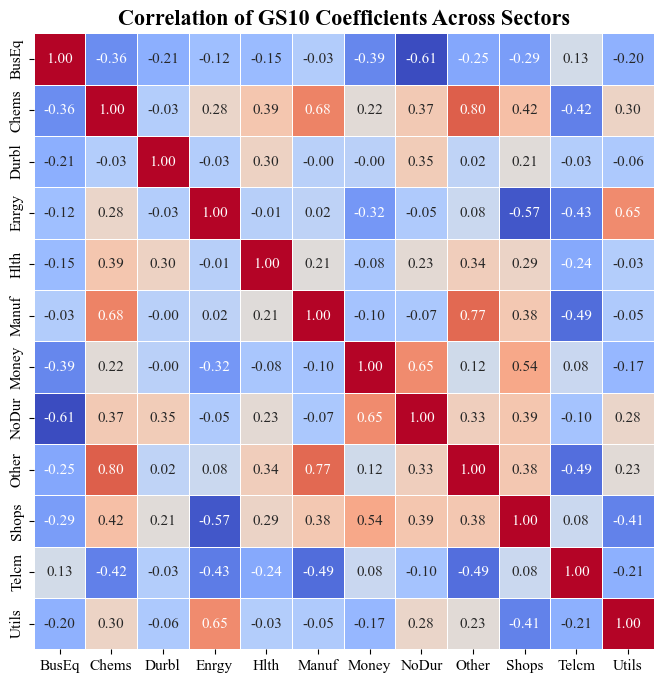

In [402]:
def run_rolling_ols_and_store_results(df_sector, segment, window_size=60):
    segment_df = df_sector[df_sector['sector'] == segment]
    rolling_results = []
    rolling_dates = []
    rolling_r_squared = []

    if len(segment_df) < window_size:
        return [], [], []  # Return empty lists if there aren't enough data

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
        rolling_results.append(model.params.get('GS10_diff', 0))  # Handle potential missing coefficients
        rolling_dates.append(segment_df['Date'].iloc[end - 1])
        rolling_r_squared.append(model.rsquared_adj.round(4))

    return rolling_dates, rolling_results, rolling_r_squared

# Assuming df_sector is your input DataFrame
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
coefficients_data = {}
r_squared_data = {}

for segment in segments:
    dates, coeffs, r_squared = run_rolling_ols_and_store_results(df_sector, segment)
    if dates:  # Check if dates list is not empty
        coefficients_data[segment] = pd.Series(coeffs, index=dates)
        r_squared_data[segment] = pd.Series(r_squared, index=dates)

coefficients_df = pd.DataFrame(coefficients_data)
r_squared_values = pd.DataFrame(r_squared_data)

# Optionally, drop rows with NaN values
coefficients_df.dropna(how='any', inplace=True)
r_squared_values.dropna(how='any', inplace=True)

# Compute the correlation matrix and plot it
correlation_matrix = coefficients_df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
plt.title('Correlation of GS10 Coefficients Across Sectors', fontweight='bold', fontsize=16)
plt.show()

# Display the head of the DataFrame
#display(coefficients_df.head())
#display(r_squared_values.head())

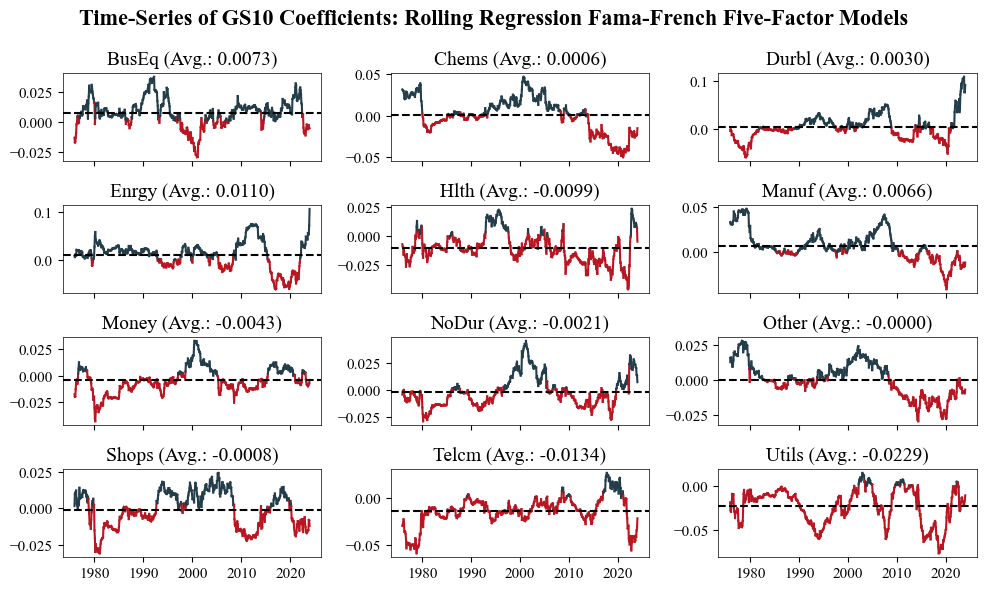

In [403]:
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 6), sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each sector's coefficients and the mean line
for i, column in enumerate(coefficients_df.columns):
    # Get the data for the current column
    y = coefficients_df[column]
    x = coefficients_df.index
    
    # Plot each segment with different colors based on value
    for j in range(1, len(y)):
        # Choose color based on value
        if y.iloc[j-1] < 0 or y.iloc[j] < 0:
            color = '#BA1621'
        else:
            color = '#233D4A'  # Change to desired color for values >= 0
        # Plot segment
        axes[i].plot(x[j-1:j+1], y.iloc[j-1:j+1], color=color)
    
    # Calculate and plot the mean line
    mean_value = y.mean()
    axes[i].axhline(y=mean_value, color='black', linestyle='--', label='Average Coefficient')
    
    # Setting titles and labels
    title_with_mean = f'{column} (Avg.: {mean_value:.4f})'
    axes[i].set_title(title_with_mean)
    axes[i].tick_params(axis='x')

# Set the main title for all subplots
fig.suptitle('Time-Series of GS10 Coefficients: Rolling Regression Fama-French Five-Factor Models', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Segment  Constant  MRP_log Coef  SMB Coef  HML Coef  RMW Coef  CMA Coef  \
0    BusEq  0.002351      1.043726  0.001023 -0.003467 -0.000981 -0.003978   
1    Chems -0.001970      1.017545 -0.000669 -0.000668  0.003087  0.003412   
2    Durbl -0.004063      1.218941  0.003360  0.002341  0.001364  0.001083   
3    Enrgy -0.002879      1.096318 -0.000662  0.002853  0.000383  0.001964   
4     Hlth  0.002078      0.829103 -0.001747 -0.005471 -0.001497  0.003208   
5    Manuf -0.002681      1.194912  0.002737  0.000256  0.000995  0.000720   
6    Money -0.000570      1.065054  0.000062  0.005857 -0.002352 -0.003435   
7    NoDur -0.001187      0.871312 -0.000331 -0.000915  0.004246  0.003440   
8    Other -0.001160      1.073653  0.001225 -0.000448 -0.001239  0.000398   
9    Shops -0.000429      0.962893  0.002520 -0.000744  0.003086  0.000368   
10   Telcm -0.000698      0.923517 -0.001089  0.000184  0.001079  0.001975   
11   Utils  0.000711      0.647214 -0.001863  0.002339 -0.002227 -0.000280   

    GS10 Coef  R-Squared  Residuals Skew  Residuals Kurtosis  Breusch-Pagan p  
0    0.007258   0.855202       -0.015650            0.735384    4.453846e-229  
1    0.000645   0.786977       -0.383646            4.230399    6.768469e-283  
2    0.003016   0.757631        0.408635            3.512451    3.212202e-117  
3    0.011016   0.585243        0.128060            0.688886    1.898801e-148  
4   -0.009853   0.699025       -0.023776            0.988516    1.664797e-160  
5    0.006553   0.880021       -0.082850            0.969382     1.873850e-20  
6   -0.004325   0.885281        0.056082            1.549109    1.315826e-131  
7   -0.002053   0.767012        0.194731            2.564491     3.869349e-31  
8   -0.000025   0.905610        0.017808            0.925053     2.309662e-97  
9   -0.000780   0.810981        0.019916            0.298190     1.929447e-46  
10  -0.013416   0.773384        0.048030            2.032047    5.136038e-126  
11  -0.022893   0.544475       -0.065814            0.597756     6.798855e-59

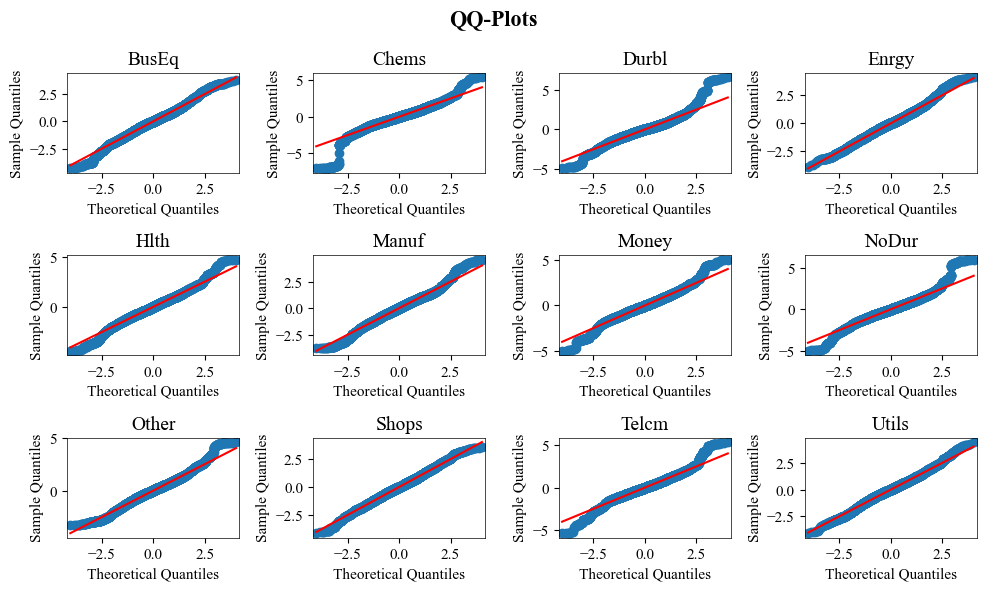

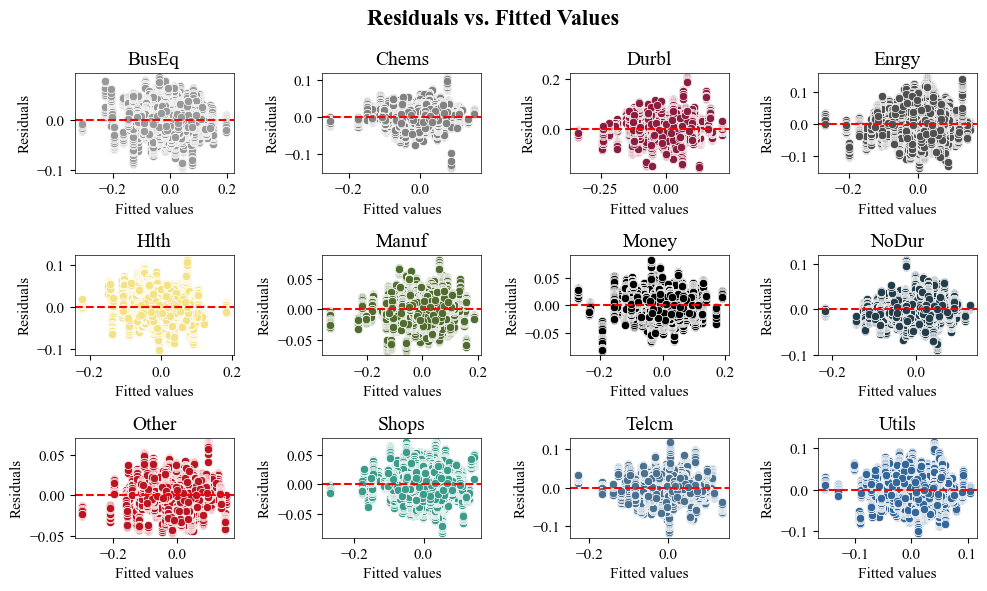

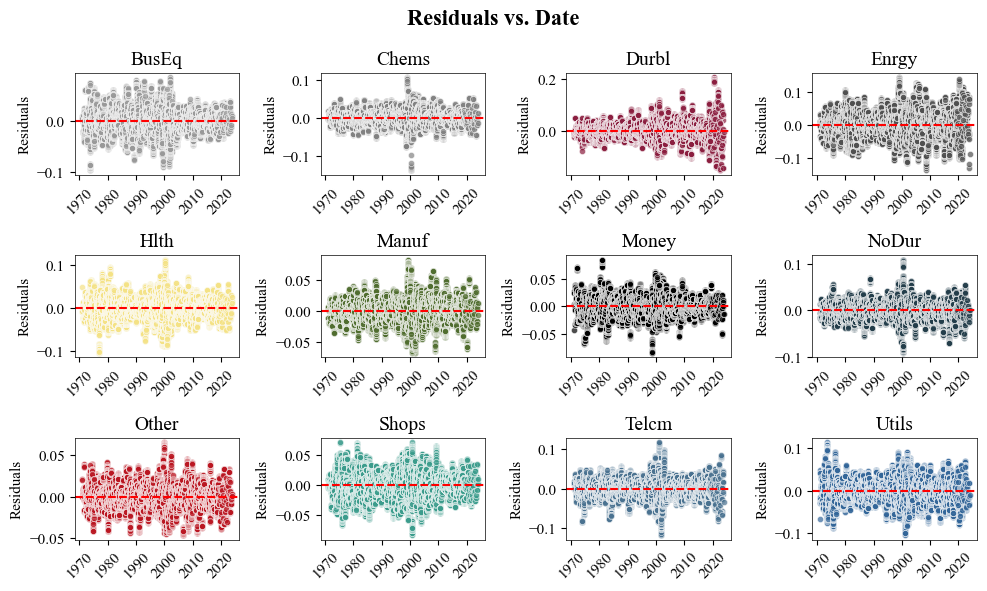

In [404]:
def run_rolling_ols_and_store_results(df_sector, segment, results_df, axes_qq, axes_res, axes_date, index, window_size=60):
    segment_df = df_sector[df_sector['sector'] == segment]
    rolling_results = []
    all_residuals = [] 
    exog_list = []  
    rolling_r_squared = []
    dates_list = []  

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
        
        rolling_results.append(model.params)
        rolling_r_squared.append(model.rsquared_adj.round(4))
        all_residuals.extend(model.resid)
        exog_list.append(X)
        dates_list.extend(segment_df['Date'].iloc[start:end])

    full_exog = pd.concat(exog_list, ignore_index=True)
    avg_params = pd.DataFrame(rolling_results).mean().to_dict()
    avg_rsq = np.mean(rolling_r_squared)
    all_residuals = np.array(all_residuals)
    _, bp_pvalue, _, _ = het_breuschpagan(all_residuals, full_exog.values)

    temp_df = pd.DataFrame({
        'Segment': [segment],
        'Constant': [avg_params['const']],
        'MRP_log Coef': [avg_params['MRP_log']],
        'SMB Coef': [avg_params['SMB']],
        'HML Coef': [avg_params['HML']],
        'RMW Coef': [avg_params['RMW']],
        'CMA Coef': [avg_params['CMA']],
        'GS10 Coef': [avg_params['GS10_diff']],
        'R-Squared': [avg_rsq],
        'Residuals Skew': [pd.Series(all_residuals).skew()],
        'Residuals Kurtosis': [pd.Series(all_residuals).kurt()],
        'Breusch-Pagan p': [bp_pvalue]
    })
    
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    # Plotting
    sns.scatterplot(x=full_exog['const'].values * avg_params['const'] + full_exog['MRP_log'].values * avg_params['MRP_log'] + 
                    full_exog['SMB'].values * avg_params['SMB'] + full_exog['HML'].values * avg_params['HML'] + 
                    full_exog['RMW'].values * avg_params['RMW'] + full_exog['CMA'].values * avg_params['CMA'] +
                    full_exog['GS10_diff'].values * avg_params['GS10_diff'], y=all_residuals, ax=axes_res[index], color=color_palette_sector.get(segment, 'grey'))
    axes_res[index].axhline(0, color='red', linestyle='dashed')
    axes_res[index].set_xlabel('Fitted values')
    axes_res[index].set_ylabel('Residuals')
    axes_res[index].set_title(f'{segment}')

    sm.qqplot(all_residuals, line='s', fit=True, ax=axes_qq[index])
    axes_qq[index].set_title(f'{segment}')

    axes_date[index].scatter(dates_list, all_residuals, color=color_palette_sector.get(segment, 'grey'), s=20 ,edgecolor='white', linewidths=.5, alpha=0.7)
    axes_date[index].axhline(0, color='red', linestyle='dashed')
    axes_date[index].set_ylabel('Residuals')
    axes_date[index].set_title(f'{segment}')
    axes_date[index].tick_params(axis='x', rotation=45)

    return results_df

# Initialization
results_df = pd.DataFrame(columns=['Segment', 'Constant', 'MRP_log Coef', 'SMB Coef', 'HML Coef', 'RMW Coef', 'CMA Coef', 'GS10 Coef', 'R-Squared', 'Residuals Skew', 'Residuals Kurtosis', 'Breusch-Pagan p'])
segments = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']
n_segments = len(segments)
n_cols = 4
n_rows = int(np.ceil(n_segments / n_cols))
fig_qq, axes_qq = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, n_rows * 2))
fig_res, axes_res = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, n_rows * 2))
fig_date, axes_date = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, n_rows * 2))
axes_qq = axes_qq.flatten()
axes_res = axes_res.flatten()
axes_date = axes_date.flatten()

# Processing
for index, segment in enumerate(segments):
    results_df = run_rolling_ols_and_store_results(df_sector, segment, results_df, axes_qq, axes_res, axes_date, index)

for i in range(n_segments, n_rows * n_cols):
    axes_qq[i].set_visible(False)
    axes_res[i].set_visible(False)
    axes_date[i].set_visible(False)


fig_qq.suptitle('QQ-Plots', fontsize=16, fontweight='bold')
fig_res.suptitle('Residuals vs. Fitted Values', fontsize=16, fontweight='bold')
fig_date.suptitle('Residuals vs. Date', fontsize=16, fontweight='bold')
fig_qq.tight_layout()
fig_res.tight_layout()
fig_date.tight_layout()

results_df = results_df.dropna()
results_df = results_df.sort_values(by='Segment', ascending=True)
display(results_df)

plt.show()

# Rolling Regressions: Debt-to-ratio portfolios
- The it not differences between the portfolios, they act pretty similar

Segment  Constant  MRP_log Coef  SMB Coef  HML Coef  RMW Coef  CMA Coef  \
0    high -0.001373      1.062145  0.000363  0.002970 -0.001143 -0.000831   
1     mid -0.000159      0.987999 -0.000468 -0.000598  0.000554  0.000833   
2     low  0.001145      0.998107  0.001510 -0.003430 -0.001251 -0.001707   

   GS10 Coef  R-Squared  Residuals Skew  Residuals Kurtosis  Breusch-Pagan p  
0  -0.000093   0.966341       -0.048199            1.590913     1.226055e-68  
1   0.000405   0.969151       -0.053986            2.100768     8.789630e-93  
2  -0.001987   0.952190       -0.025398            1.309015    9.582577e-117

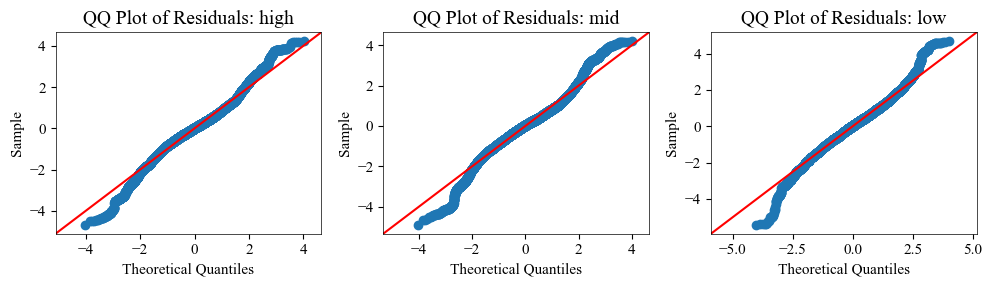

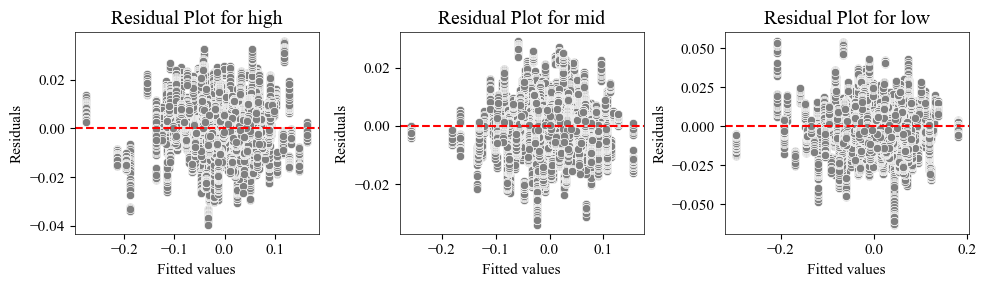

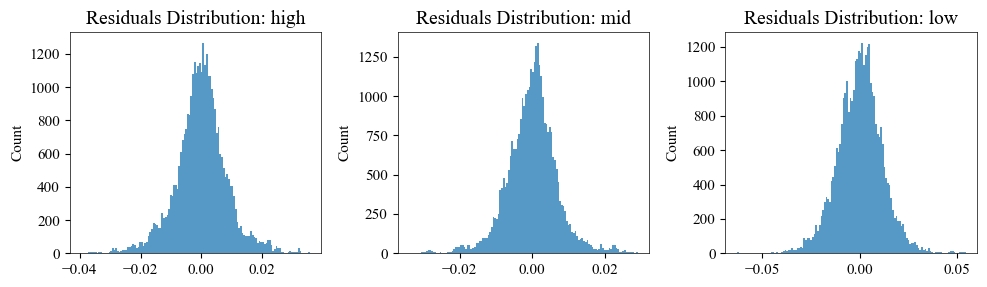

In [405]:
def run_rolling_ols_and_store_results(df_dr, segment, results_df, axes_qq, axes_res, axes_hist, index, window_size=60):
    segment_df = df_dr[df_dr['DR_port'] == segment]
    rolling_results = []
    all_residuals = []  # List to store residuals from all models
    exog_list = []  # Store exogenous variables for each model to match residuals
    rolling_r_squared = []

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})

        rolling_results.append(model.params)
        rolling_r_squared.append(model.rsquared_adj.round(4))
        all_residuals.extend(model.resid)  # Store residuals from each model
        exog_list.append(X)  # Store corresponding exogenous variables

    # Concatenate all exogenous variable dataframes
    full_exog = pd.concat(exog_list, ignore_index=True)

    # Averaging model parameters
    avg_params = pd.DataFrame(rolling_results).mean().to_dict()
    avg_rsq = avg_rsq = np.mean(rolling_r_squared)

    all_residuals = np.array(all_residuals)  # Convert list of residuals to array for analysis
    _, bp_pvalue, _, _ = het_breuschpagan(all_residuals, full_exog.values)

    # Append averaged results and aggregated residual statistics
    temp_df = pd.DataFrame({
        'Segment': [segment],
        'Constant': [avg_params['const']],
        'MRP_log Coef': [avg_params['MRP_log']],
        'SMB Coef': [avg_params['SMB']],
        'HML Coef': [avg_params['HML']],
        'RMW Coef': [avg_params['RMW']],
        'CMA Coef': [avg_params['CMA']],
        'GS10 Coef': [avg_params['GS10_diff']],
        'R-Squared': [avg_rsq],
        'Residuals Skew': [pd.Series(all_residuals).skew()],
        'Residuals Kurtosis': [pd.Series(all_residuals).kurt()],
        'Breusch-Pagan p': [bp_pvalue]
    })
    
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    # Plotting for all residuals in the rolling window
    sns.scatterplot(x=full_exog['const'].values * avg_params['const'] + full_exog['MRP_log'].values * avg_params['MRP_log'] + full_exog['SMB'].values * avg_params['SMB'] + 
                    full_exog['HML'].values * avg_params['HML'] + full_exog['RMW'].values * avg_params['RMW'] + full_exog['CMA'].values * avg_params['CMA'] +
                    full_exog['GS10_diff'].values * avg_params['GS10_diff'], y=all_residuals, ax=axes_res[index], color=color_palette_sector.get(segment, 'grey'))
    axes_res[index].axhline(0, color='red', linestyle='dashed')
    axes_res[index].set_xlabel('Fitted values')
    axes_res[index].set_ylabel('Residuals')
    axes_res[index].set_title(f'Residual Plot for {segment}')
    sm.qqplot(all_residuals, line='45', fit=True, ax=axes_qq[index])
    axes_qq[index].set_title(f'QQ Plot of Residuals: {segment}')
    axes_qq[index].set_ylabel('Sample')
    sns.histplot(all_residuals, ax=axes_hist[index])
    axes_hist[index].set_title(f'Residuals Distribution: {segment}')
    return results_df

# Initialize the figure and axes for the plots and continue as in your original setup.
results_df = pd.DataFrame(columns=['Segment', 'Constant', 'MRP_log Coef', 'SMB Coef', 'HML Coef', 'RMW Coef', 'CMA Coef', 'GS10 Coef', 'R-Squared', 'Residuals Skew', 'Residuals Kurtosis', 'Breusch-Pagan p'])

# Assuming df_sector is your input DataFrame
segments = ['high', 'mid', 'low']
n_segments = len(segments)
n_cols = 3
n_rows = int(np.ceil(n_segments / n_cols))
fig_qq, axes_qq = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 3))
fig_res, axes_res = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 3))
fig_hist, axes_hist = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 3))
axes_qq = axes_qq.flatten()
axes_res = axes_res.flatten()
axes_hist = axes_hist.flatten()

for index, segment in enumerate(segments):
    results_df = run_rolling_ols_and_store_results(df_dr, segment, results_df, axes_qq, axes_res, axes_hist, index)

for i in range(n_segments, n_rows * n_cols):
    axes_qq[i].set_visible(False)
    axes_res[i].set_visible(False)
    axes_hist[i].set_visible(False)

fig_hist.tight_layout()
fig_qq.tight_layout()
fig_res.tight_layout()


results_df = results_df.dropna()
results_df = results_df.sort_values(by='Segment', ascending=True)
order = ['high', 'mid', 'low']
# Convert 'Segment' to a categorical type with the specified order
results_df['Segment'] = pd.Categorical(results_df['Segment'], categories=order, ordered=True)
# Sort the DataFrame by 'Segment'
results_df = results_df.sort_values('Segment')

display(results_df)

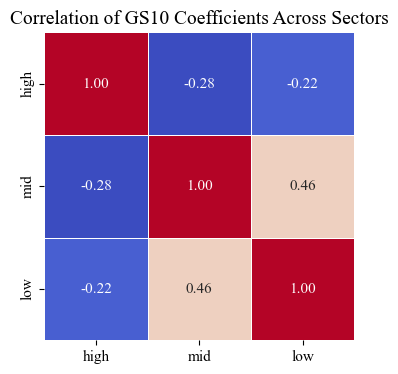

high       mid       low
1975-12-01 -0.002506  0.020101  0.001083
1976-01-01 -0.001999  0.018719 -0.000273
1976-02-01 -0.001545  0.019302  0.000396
1976-03-01  0.004027  0.017790  0.001004
1976-04-01  0.005108  0.014498  0.002945

high     mid     low
1975-12-01  0.9543  0.9712  0.9660
1976-01-01  0.9564  0.9723  0.9677
1976-02-01  0.9565  0.9725  0.9678
1976-03-01  0.9580  0.9725  0.9675
1976-04-01  0.9577  0.9709  0.9662

In [406]:
def run_rolling_ols_and_store_results(df_dr, segment, window_size=60):
    segment_df = df_dr[df_dr['DR_port'] == segment]
    rolling_results = []
    rolling_dates = []
    rolling_r_squared = []

    if len(segment_df) < window_size:
        return [], [], []  # Return empty lists if there aren't enough data

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
        rolling_results.append(model.params.get('GS10_diff', 0))  # Handle potential missing coefficients
        rolling_dates.append(segment_df['Date'].iloc[end - 1])
        rolling_r_squared.append(model.rsquared_adj.round(4))

    return rolling_dates, rolling_results, rolling_r_squared

# Assuming df_dr_sector_avg is your input DataFrame
segments = ['high', 'mid', 'low']
coefficients_data = {}
r_squared_data = {}

for segment in segments:
    dates, coeffs, r_squared = run_rolling_ols_and_store_results(df_dr, segment)
    if dates:  # Check if dates list is not empty
        coefficients_data[segment] = pd.Series(coeffs, index=dates)
        r_squared_data[segment] = pd.Series(r_squared, index=dates)

coefficients_df = pd.DataFrame(coefficients_data)
r_squared_values = pd.DataFrame(r_squared_data)

# Optionally, drop rows with NaN values
coefficients_df.dropna(how='any', inplace=True)
r_squared_values.dropna(how='any', inplace=True)

# Compute the correlation matrix and plot it
correlation_matrix = coefficients_df.corr()
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
plt.title('Correlation of GS10 Coefficients Across Sectors')
plt.show()

# Display the head of the DataFrame
display(coefficients_df.head())
display(r_squared_values.head())

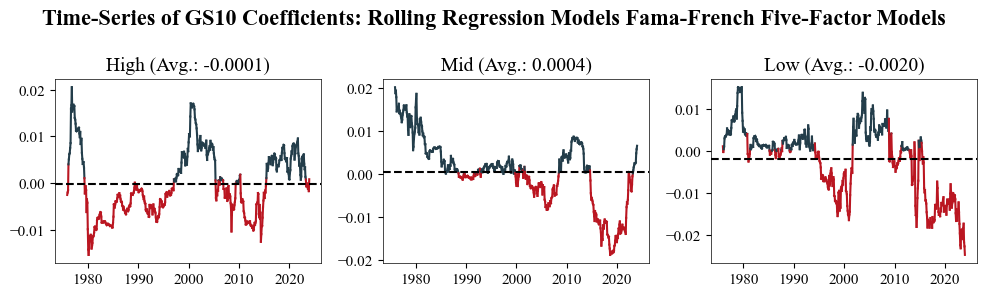

In [407]:
# Change the column names to start with capital letter
coefficients_df.columns = [col.capitalize() for col in coefficients_df.columns]

# Create a 4x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each sector's coefficients and the mean line
for i, column in enumerate(coefficients_df.columns):
    # Get the data for the current column
    y = coefficients_df[column]
    x = coefficients_df.index
    
    # Plot each segment with different colors based on value
    for j in range(1, len(y)):
        # Choose color based on value
        if y.iloc[j-1] < 0 or y.iloc[j] < 0:
            color = '#BA1621'
        else:
            color = '#233D4A'  # Change to desired color for values >= 0
        # Plot segment
        axes[i].plot(x[j-1:j+1], y.iloc[j-1:j+1], color=color)
    
    # Calculate and plot the mean line
    mean_value = y.mean()
    axes[i].axhline(y=mean_value, color='black', linestyle='--', label='Average Coefficient')
    
    # Setting titles and labels
    title_with_mean = f'{column} (Avg.: {mean_value:.4f})'
    axes[i].set_title(title_with_mean)
    axes[i].tick_params(axis='x')

# Set the main title for all subplots
fig.suptitle('Time-Series of GS10 Coefficients: Rolling Regression Models Fama-French Five-Factor Models', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Debt Ratio in porportion to sectors

Segment  Constant  MRP_log Coef  SMB Coef  HML Coef  RMW Coef  CMA Coef  \
0    high   -0.0011        1.0610    0.0011    0.0011   -0.0001    0.0007   
1     mid    0.0000        0.9746    0.0001   -0.0000    0.0005    0.0009   
2     low   -0.0001        0.9700    0.0026   -0.0010   -0.0005   -0.0003   

   GS10 Coef  R-Squared  Residuals Skew  Residuals Kurtosis  Breusch-Pagan p  
0     0.0005   0.963870        0.307209            1.782158    5.483334e-182  
1    -0.0031   0.971363        0.078746            2.378506     4.239004e-83  
2    -0.0059   0.961379       -0.009856            1.457440    1.414812e-130

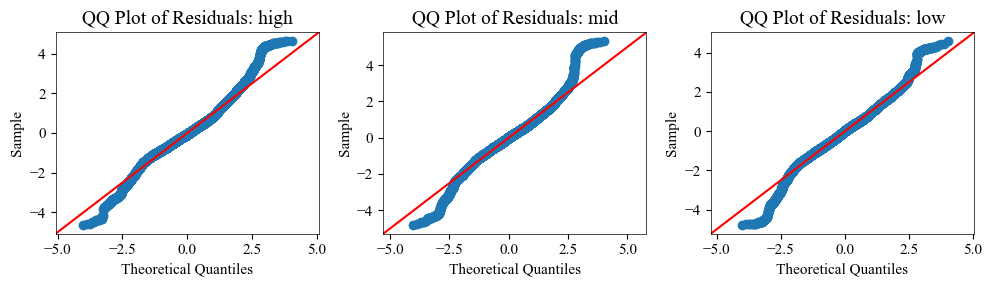

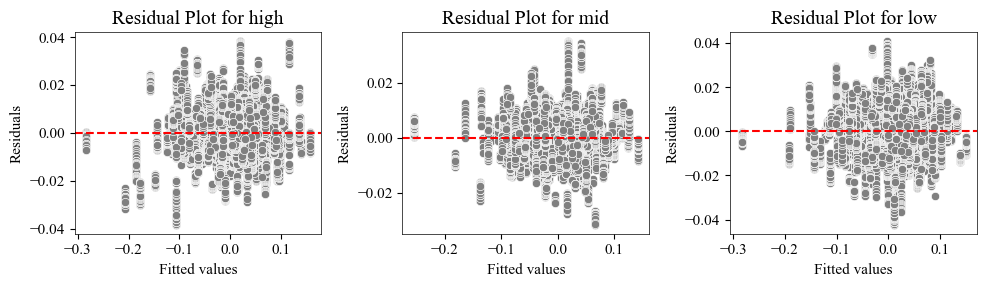

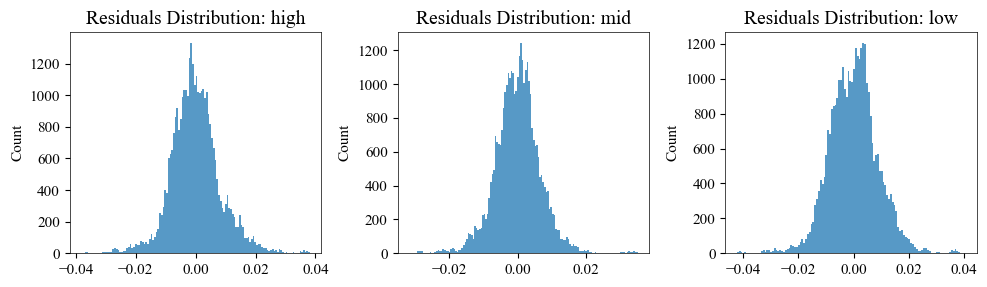

In [408]:
def run_rolling_ols_and_store_results(df_dr_sector_avg, segment, results_df, axes_qq, axes_res, axes_hist, index, window_size=60):
    segment_df = df_dr_sector_avg[df_dr_sector_avg['DR'] == segment]
    rolling_results = []
    all_residuals = []  # List to store residuals from all models
    exog_list = []  # Store exogenous variables for each model to match residuals
    rolling_r_squared = []

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})

        rolling_results.append(model.params)
        rolling_r_squared.append(model.rsquared_adj.round(4))
        all_residuals.extend(model.resid)  # Store residuals from each model
        exog_list.append(X)  # Store corresponding exogenous variables

    # Concatenate all exogenous variable dataframes
    full_exog = pd.concat(exog_list, ignore_index=True)

    # Averaging model parameters
    avg_params = pd.DataFrame(rolling_results).mean().round(4).to_dict()
    avg_rsq = avg_rsq = np.mean(rolling_r_squared)

    all_residuals = np.array(all_residuals)  # Convert list of residuals to array for analysis
    _, bp_pvalue, _, _ = het_breuschpagan(all_residuals, full_exog.values)

    # Append averaged results and aggregated residual statistics
    temp_df = pd.DataFrame({
        'Segment': [segment],
        'Constant': [avg_params['const']],
        'MRP_log Coef': [avg_params['MRP_log']],
        'SMB Coef': [avg_params['SMB']],
        'HML Coef': [avg_params['HML']],
        'RMW Coef': [avg_params['RMW']],
        'CMA Coef': [avg_params['CMA']],
        'GS10 Coef': [avg_params['GS10_diff']],
        'R-Squared': [avg_rsq],
        'Residuals Skew': [pd.Series(all_residuals).skew()],
        'Residuals Kurtosis': [pd.Series(all_residuals).kurt()],
        'Breusch-Pagan p': [bp_pvalue]
    })
    
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    # Plotting for all residuals in the rolling window
    sns.scatterplot(x=full_exog['const'].values * avg_params['const'] + full_exog['MRP_log'].values * avg_params['MRP_log'] + full_exog['SMB'].values * avg_params['SMB'] + 
                    full_exog['HML'].values * avg_params['HML'] + full_exog['RMW'].values * avg_params['RMW'] + full_exog['CMA'].values * avg_params['CMA'] +
                    full_exog['GS10_diff'].values * avg_params['GS10_diff'], y=all_residuals, ax=axes_res[index], color=color_palette_sector.get(segment, 'grey'))
    axes_res[index].axhline(0, color='red', linestyle='dashed')
    axes_res[index].set_xlabel('Fitted values')
    axes_res[index].set_ylabel('Residuals')
    axes_res[index].set_title(f'Residual Plot for {segment}')
    sm.qqplot(all_residuals, line='45', fit=True, ax=axes_qq[index])
    axes_qq[index].set_title(f'QQ Plot of Residuals: {segment}')
    axes_qq[index].set_ylabel('Sample')
    sns.histplot(all_residuals, ax=axes_hist[index])
    axes_hist[index].set_title(f'Residuals Distribution: {segment}')
    return results_df

# Initialize the figure and axes for the plots and continue as in your original setup.
results_df = pd.DataFrame(columns=['Segment', 'Constant', 'MRP_log Coef', 'SMB Coef', 'HML Coef', 'RMW Coef', 'CMA Coef', 'GS10 Coef', 'R-Squared', 'Residuals Skew', 'Residuals Kurtosis', 'Breusch-Pagan p'])

# Assuming df_sector is your input DataFrame
segments = ['high', 'mid', 'low']
n_segments = len(segments)
n_cols = 3
n_rows = int(np.ceil(n_segments / n_cols))
fig_qq, axes_qq = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 3))
fig_res, axes_res = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 3))
fig_hist, axes_hist = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 3))
axes_qq = axes_qq.flatten()
axes_res = axes_res.flatten()
axes_hist = axes_hist.flatten()

for index, segment in enumerate(segments):
    results_df = run_rolling_ols_and_store_results(df_dr_sector_avg, segment, results_df, axes_qq, axes_res, axes_hist, index)

for i in range(n_segments, n_rows * n_cols):
    axes_qq[i].set_visible(False)
    axes_res[i].set_visible(False)
    axes_hist[i].set_visible(False)

fig_hist.tight_layout()
fig_qq.tight_layout()
fig_res.tight_layout()


results_df = results_df.dropna()
results_df = results_df.sort_values(by='Segment', ascending=True)
order = ['high', 'mid', 'low']
# Convert 'Segment' to a categorical type with the specified order
results_df['Segment'] = pd.Categorical(results_df['Segment'], categories=order, ordered=True)
# Sort the DataFrame by 'Segment'
results_df = results_df.sort_values('Segment')

display(results_df)

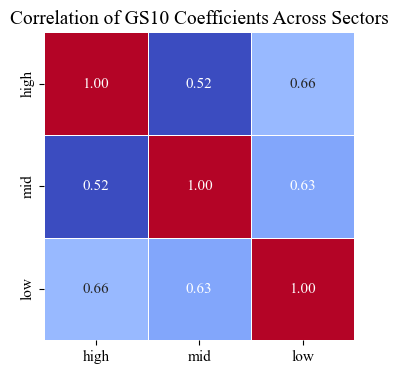

high       mid       low
1975-12-01  0.006296 -0.001388  0.001219
1976-01-01  0.005810 -0.002555  0.000898
1976-02-01  0.005202 -0.001655  0.001112
1976-03-01  0.008521  0.000015  0.002005
1976-04-01  0.008862 -0.001312  0.002884

high     mid     low
1975-12-01  0.9736  0.9811  0.9871
1976-01-01  0.9764  0.9823  0.9879
1976-02-01  0.9767  0.9825  0.9880
1976-03-01  0.9772  0.9813  0.9879
1976-04-01  0.9772  0.9821  0.9875

high    0.9639
mid     0.9714
low     0.9614
dtype: float64

In [409]:
def run_rolling_ols_and_store_results(df_dr_sector_avg, segment, window_size=60):
    segment_df = df_dr_sector_avg[df_dr_sector_avg['DR'] == segment]
    rolling_results = []
    rolling_dates = []
    rolling_r_squared = []

    if len(segment_df) < window_size:
        return [], [], []  # Return empty lists if there aren't enough data

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP_log', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
        rolling_results.append(model.params.get('GS10_diff', 0))  # Handle potential missing coefficients
        rolling_dates.append(segment_df['Date'].iloc[end - 1])
        rolling_r_squared.append(model.rsquared_adj.round(4))

    return rolling_dates, rolling_results, rolling_r_squared

# Assuming df_dr_sector_avg is your input DataFrame
segments = ['high', 'mid', 'low']
coefficients_data = {}
r_squared_data = {}

for segment in segments:
    dates, coeffs, r_squared = run_rolling_ols_and_store_results(df_dr_sector_avg, segment)
    if dates:  # Check if dates list is not empty
        coefficients_data[segment] = pd.Series(coeffs, index=dates)
        r_squared_data[segment] = pd.Series(r_squared, index=dates)

coefficients_df = pd.DataFrame(coefficients_data)
r_squared_values = pd.DataFrame(r_squared_data)

# Optionally, drop rows with NaN values
coefficients_df.dropna(how='any', inplace=True)
r_squared_values.dropna(how='any', inplace=True)

# Compute the correlation matrix and plot it
correlation_matrix = coefficients_df.corr()
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
plt.title('Correlation of GS10 Coefficients Across Sectors')
plt.show()

# Display the head of the DataFrame
display(coefficients_df.head())
display(r_squared_values.head())

# Print the average r-square values for each segment
r_squared_values.mean().round(4)

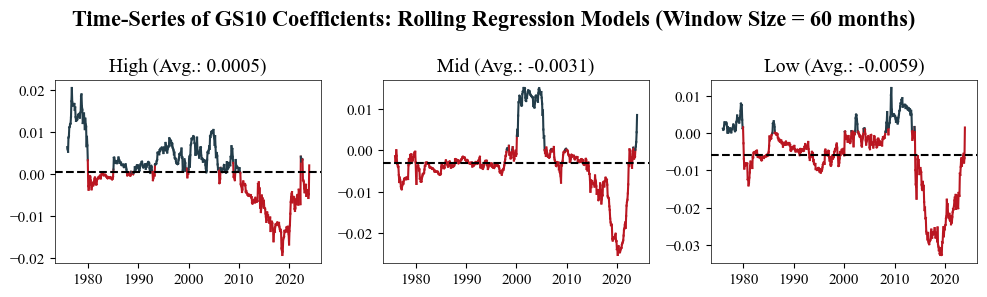

In [410]:
# Change the column names to start with capital letter
coefficients_df.columns = [col.capitalize() for col in coefficients_df.columns]

# Create a 4x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each sector's coefficients and the mean line
for i, column in enumerate(coefficients_df.columns):
    # Get the data for the current column
    y = coefficients_df[column]
    x = coefficients_df.index
    
    # Plot each segment with different colors based on value
    for j in range(1, len(y)):
        # Choose color based on value
        if y.iloc[j-1] < 0 or y.iloc[j] < 0:
            color = '#BA1621'
        else:
            color = '#233D4A'  # Change to desired color for values >= 0
        # Plot segment
        axes[i].plot(x[j-1:j+1], y.iloc[j-1:j+1], color=color)
    
    # Calculate and plot the mean line
    mean_value = y.mean()
    axes[i].axhline(y=mean_value, color='black', linestyle='--', label='Average Coefficient')
    
    # Setting titles and labels
    title_with_mean = f'{column} (Avg.: {mean_value:.4f})'
    axes[i].set_title(title_with_mean)
    axes[i].tick_params(axis='x')

# Set the main title for all subplots
fig.suptitle('Time-Series of GS10 Coefficients: Rolling Regression Models (Window Size = 60 months)', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Debt ratio sector segmented portfolios

In [411]:
def run_rolling_ols_and_store_results(df_dr_sector, segment, window_size=60):
    segment_df = df_dr_sector[df_dr_sector['DR_sector_port'] == segment]
    rolling_results = []
    rolling_dates = []
    rolling_r_squared = []

    if len(segment_df) < window_size:
        return [], [], []  # Return empty lists if there aren't enough data

    for start in range(len(segment_df) - window_size + 1):
        end = start + window_size
        X = segment_df[['MRP', 'SMB', 'HML', 'RMW', 'CMA', 'GS10_diff']].iloc[start:end]
        X = sm.add_constant(X)
        y = segment_df['excess_return_log'].iloc[start:end]
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
        rolling_results.append(model.params.get('GS10_diff', 0))  # Handle potential missing coefficients
        rolling_dates.append(segment_df['Date'].iloc[end - 1])
        rolling_r_squared.append(model.rsquared_adj.round(4))

    return rolling_dates, rolling_results, rolling_r_squared

# Assuming df_sector is your input DataFrame
segments = ['BusEq_high', 'BusEq_mid', 'BusEq_low', 'Chems_high', 'Chems_mid', 'Chems_low', 'Durbl_high', 'Durbl_mid', 'Durbl_low', 'Enrgy_high', 'Enrgy_mid', 'Enrgy_low', 'Hlth_high', 
            'Hlth_mid', 'Hlth_low', 'Manuf_high', 'Manuf_mid', 'Manuf_low', 'Money_high', 'Money_mid', 'Money_low', 'NoDur_high', 'NoDur_mid', 'NoDur_low', 'Other_high', 'Other_mid', 
            'Other_low', 'Shops_high', 'Shops_mid', 'Shops_low', 'Telcm_high', 'Telcm_mid', 'Telcm_low', 'Utils_high', 'Utils_mid', 'Utils_low']
coefficients_data = {}
r_squared_data = {}

for segment in segments:
    dates, coeffs, r_squared = run_rolling_ols_and_store_results(df_dr_sector, segment)
    if dates:  # Check if dates list is not empty
        coefficients_data[segment] = pd.Series(coeffs, index=dates)
        r_squared_data[segment] = pd.Series(r_squared, index=dates)

coefficients_df = pd.DataFrame(coefficients_data)
r_squared_values = pd.DataFrame(r_squared_data)

# Optionally, drop rows with NaN values
coefficients_df.dropna(how='any', inplace=True)
r_squared_values.dropna(how='any', inplace=True)

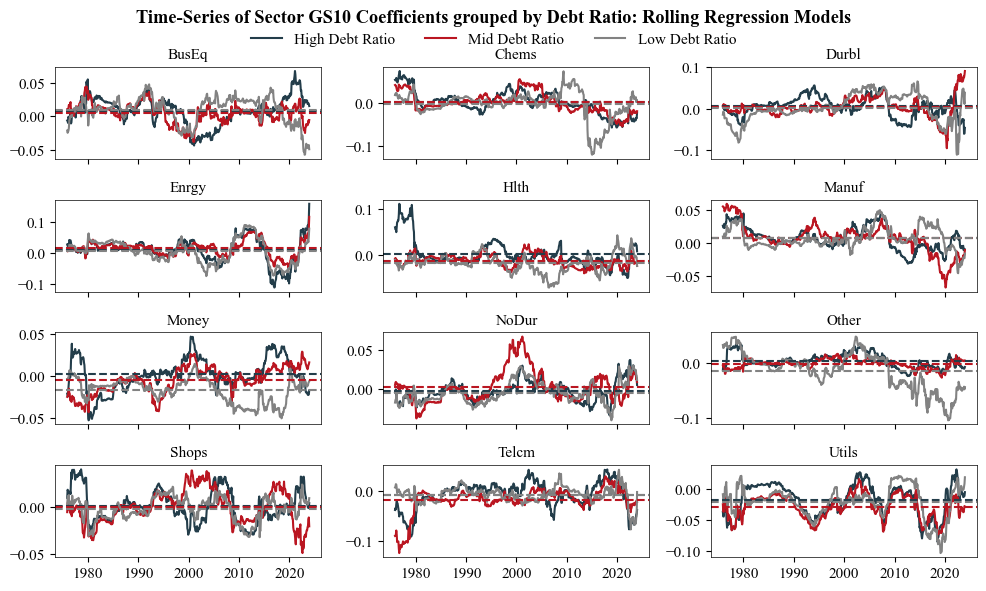

In [412]:
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 6), sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Names of the sectors to plot for each subplot
sectors = ['BusEq', 'Chems', 'Durbl', 'Enrgy', 'Hlth', 'Manuf', 'Money', 'NoDur', 'Other', 'Shops', 'Telcm', 'Utils']

# Iterate over each subplot and plot data for each sector
for i, sector in enumerate(sectors):
    # Extract data for each group within the sector
    y_high = coefficients_df[f'{sector}_high']
    y_mid = coefficients_df[f'{sector}_mid']
    y_low = coefficients_df[f'{sector}_low']
    x = coefficients_df.index

    axes[i].plot(x, y_high, label='High Debt Ratio', color='#233D4A')
    axes[i].plot(x, y_mid, label='Mid Debt Ratio', color='#BA1621')
    axes[i].plot(x, y_low, label='Low Debt Ratio', color='#828282')

    # Calculate and plot the mean line for each group
    mean_high = y_high.mean()
    mean_mid = y_mid.mean()
    mean_low = y_low.mean()

    axes[i].axhline(y=mean_high, color='#233D4A', linestyle='--')
    axes[i].axhline(y=mean_mid, color='#BA1621', linestyle='--')
    axes[i].axhline(y=mean_low, color='#828282', linestyle='--')

    # Setting titles and labels
    axes[i].set_title(sector, fontsize=11)

# Set the main title for all subplots
fig.suptitle('Time-Series of Sector GS10 Coefficients grouped by Debt Ratio: Rolling Regression Models', fontweight='bold')

# Adjust the spacing between the plots
plt.subplots_adjust(hspace=0.4, top=0.9)

# Add a legend below the suptitle
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.965))

# Show the plot
plt.tight_layout()
plt.show()

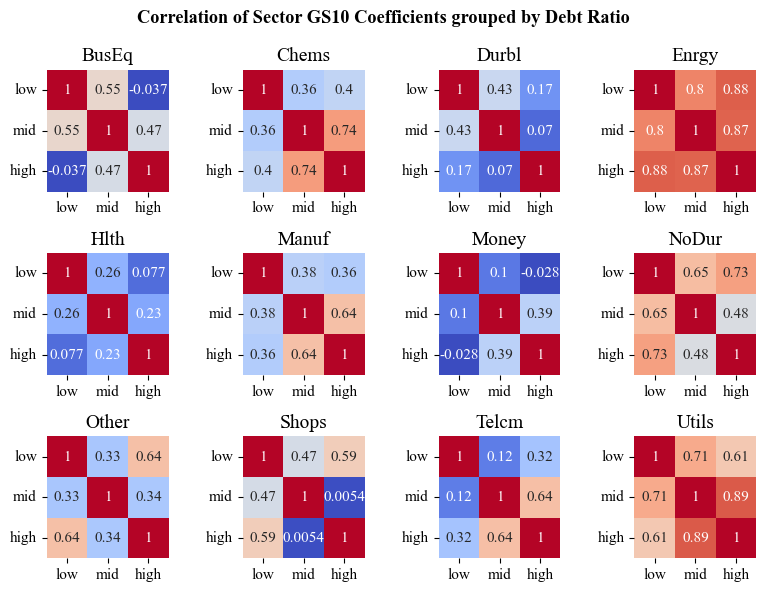

In [413]:
# Identify the unique sectors
columns = coefficients_df.columns
sectors = sorted(set(col.split('_')[0] for col in columns))
cols = 4  
rows = 3  

fig, axes = plt.subplots(rows, cols, figsize=(8, 6))
axes = axes.flatten()  # Flatten the array to make indexing easier

# Loop through each sector and create a single heatmap that includes all groups
for i, sector in enumerate(sectors):
    group_labels = ['low', 'mid', 'high']
    all_groups = []

    for group in group_labels:
        relevant_columns = [col for col in columns if col.startswith(f'{sector}_{group}')]
        if relevant_columns:
            all_groups.append(coefficients_df[relevant_columns].mean(axis=1))  # Use the mean to represent the group

    # Create a DataFrame for the correlation matrix
    if all_groups:
        group_df = pd.concat(all_groups, axis=1)
        group_df.columns = group_labels
        
        # Compute the correlation matrix
        corr_matrix = group_df.corr()
        
        # Plot the heatmap
        sns.heatmap(corr_matrix, ax=axes[i], annot=True, cmap='coolwarm', vmin=0, vmax=1, square=True, cbar=False)
        axes[i].set_title(f'{sector}')
        axes[i].tick_params(axis='x', rotation=0)
        axes[i].tick_params(axis='y', rotation=0)

# Turn off any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Set the main title for all subplots
fig.suptitle('Correlation of Sector GS10 Coefficients grouped by Debt Ratio', fontweight='bold')

plt.tight_layout()
plt.show()
